In [1]:
from pv_analyzer import pv_analyze
import numpy as np
import Tb_estimator as tb_est
from lteanalysis import LTEAnalysis
import corner
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
%matplotlib widget

## Rs with empkep

In [3]:
res_prefix = 'rs_empkep_fixr_rms_jscurve_lwerN_bnds_54' # t1 -- > Normal results with corrections, t0 before corrections

### Some functions

In [4]:
def emp_kep_v(v_rot, v_100):        
        r_au = 100.*np.power(v_100/v_rot, 2)
        return r_au

def emp_kep_r(r, r_b, v_100):
        v_r = v_100*(r/r_b)**(-0.5)
        return v_r

In [5]:
def get_lte_grid(model, Ncol:list=[1.e17], Texe:list=[15.], tb7:float=10., tb6:float=8.,
                  figure=None, axes=None):
    """
    Parameters:
    -----------
    Ncol: list of column densities, by default assumes lower quantile, median and, upper quantile
    Texe: list of Excitation temperatures, by default assumes lower quantile, median and, upper quantile
    """

    Ncols = np.array([5.e11, Ncol[1], 1.e19]) # cm^-2  
    Texes = np.array([5, Texe[1],30., 60]) # K
    dv =    [7417.8, 7417.8] #    [7417.8, 7417.8] [0.5, 0.5]
    Xconv = 1.

    fig, ax = model.makegrid(lines = 'c18o', J1=3, J2=2, Ncols = Ncols, Texes = Texes, 
                             delv = dv, fig = figure, ax = axes)

    Tb_7_pred = []
    Tb_6_pred = []
    Taunu_7_pred = []
    Taunu_6_pred = []


    for ni, nc in enumerate(Ncol):
        for ti, te in enumerate(Texe):
            Tb_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None))
            Taunu_7_pred.append(model.get_intensity(line = 'c18o', Ju = 3, Ncol = nc,
                                                  Tex = te, delv = dv[0], Xconv=None, return_tau = True))
            Tb_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None))
            Taunu_6_pred.append(model.get_intensity(line = 'c18o', Ju = 2, Ncol = nc,
                                                  Tex = te, delv = dv[1], Xconv=None, return_tau = True) )

            
    # Get theoretical errors at median values
    Tb7_med, Tb7_dIv_dN, Tb7_dIv_dT = model.get_intensity(line = 'c18o', Ju = 3, Ncol = Ncol[1], Tex =Texe[1], delv = dv[0], 
                                                           Xconv=None, return_errs = True)
    Tb6_med, Tb6_dIv_dN, Tb6_dIv_dT = model.get_intensity(line = 'c18o', Ju = 2, Ncol = Ncol[1], Tex =Texe[1], delv = dv[1], 
                                                           Xconv=None, return_errs = True)
    

    print(f"Tb7_dIv_dN = {Tb7_dIv_dN:.2e}, Tb6_dIv_dN = {Tb6_dIv_dN:.2e}")
    print(f"Tb7_dIv_dT = {Tb7_dIv_dT:.2f}, Tb6_dIv_dT = {Tb6_dIv_dT:.2f}")


    del_T_up = Texe[2] - Texe[1]
    del_T_dwn = Texe[1] - Texe[0]
    del_N_up = Ncol[2] - Ncol[1]
    del_N_dwn = Ncol[1] - Ncol[0]

    print(f"Ncols and lgNcols up {Ncol[2]:.2e}, lgNc = {np.log10(Ncol[2]):.2e}")
    print(f"Ncols and lgNcols med {Ncol[1]:.2e}, lgNc = {np.log10(Ncol[1]):.2e}")
    print(f"Ncols and lgNcols dwn {Ncol[0]:.2e}, lgNc = {np.log10(Ncol[0]):.2e}")

    print(f"del T -> + {del_T_up:.2f}, - {del_T_dwn:.2f}")
    print(f"del N -> + {del_N_up:.2e}, - {del_N_dwn:.2e}")

    Tb7_err_up = np.sqrt((del_N_up*Xconv*Tb7_dIv_dN)**2 + (del_T_up*Tb7_dIv_dT)**2)
    Tb7_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb7_dIv_dN)**2 + (del_T_dwn*Tb7_dIv_dT)**2)
    Tb7_thr_err = np.array([[Tb7_err_dwn, Tb7_err_up]])


    Tb6_err_up = np.sqrt((del_N_up*Xconv*Tb6_dIv_dN)**2 + (del_T_up*Tb6_dIv_dT)**2)
    Tb6_err_dwn = np.sqrt((del_N_dwn*Xconv*Tb6_dIv_dN)**2 + (del_T_dwn*Tb6_dIv_dT)**2)
    Tb6_thr_err = np.array([[Tb6_err_dwn, Tb6_err_up]])

    print("Error propagation results:")
    print(r"$\Delta Tb_{6}$", Tb6_thr_err)
    print(r"$\Delta Tb_{7}$", Tb7_thr_err)

    Tb_7_err = np.array([[Tb_7_pred[4] - min(Tb_7_pred), max(Tb_7_pred) - Tb_7_pred[4]]])
    Tb_6_err = np.array([[Tb_6_pred[4]-min(Tb_6_pred), max(Tb_6_pred) - Tb_6_pred[4]]])
    
    Taunu_7_err = np.array([[Taunu_7_pred[4] - min(Taunu_7_pred), max(Taunu_7_pred) - Taunu_7_pred[4]]])
    Taunu_6_err = np.array([[Taunu_6_pred[4] - min(Taunu_6_pred), max(Taunu_6_pred) - Taunu_6_pred[4]]])
    
    ax.errorbar(Tb_7_pred[4], Tb_6_pred[4], xerr=Tb_7_err.T, yerr=Tb_6_err.T,
                color = 'green', marker = '^', label = 'Fit', capsize=5.)
    
    ax.errorbar(Tb7_med, Tb6_med, xerr=Tb7_thr_err.T, yerr=Tb6_thr_err.T,
                color = 'k', marker = '^', capsize = 5.0, alpha = 0.5)
    
    ax.errorbar(tb7, tb6, xerr = np.sqrt(1.08**2),   # (0.1*tb7)**2 + 1.08**2
                yerr = np.sqrt(0.49**2),  # (0.1*tb6)**2 + 0.49**2
                color = 'red', marker = 'o', ms=5, capsize=5., label = 'Observed')
    
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

    plt.grid()
    plt.legend(prop={'size': 6})

    return fig, ax, (Tb_6_pred[4], Tb_6_err, Taunu_6_pred[4], Taunu_6_err),\
          (Tb_7_pred[4], Tb_7_err, Taunu_7_pred[4], Taunu_7_err)

### Temperature estimation (fix v)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_69_w1.fits',
                    v_sys=7.27, is_Tb=True)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.45e-02 Jy beam$^-1$
 rms = 1.08 K
Convert frequency to velocity
 rms = 6.92e-03 Jy beam$^-1$
 rms = 0.49 K


In [7]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674},)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = emp_kep_v, mode='func',
                                get_surrounding_pix = True, num_pix = 5,  get_pix_along='v',
                                cf_kwargs = {'v_100':2.674})

In [ ]:
v_100 = 2.674
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

#### Data Visualization

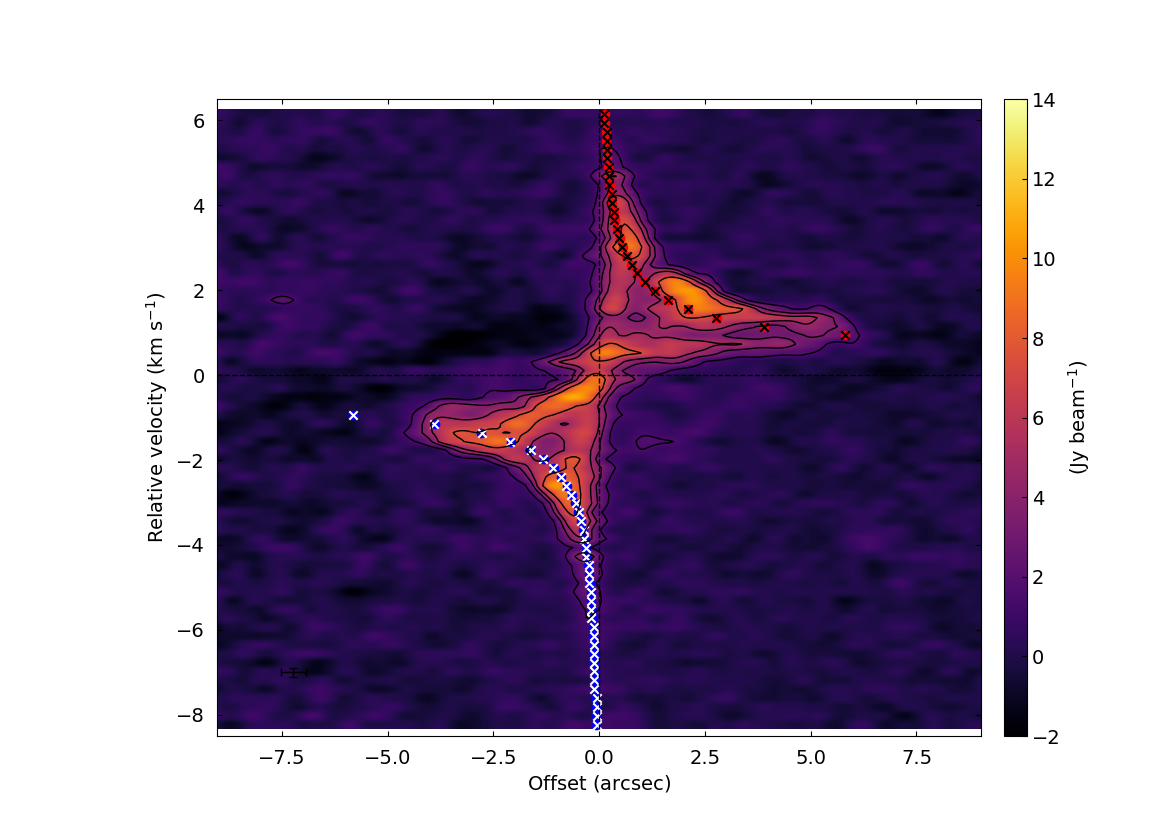

In [8]:
pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)
pv_dia7 = pv_b7.plot_pv(plot_curve=True)

#### T estimation loop(fix v)

In [10]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.094e-01 arcsec, v =  4.06 Kmps , Tb7 = 7.1, Tb6 = 6.2


100%|██████████| 10000/10000 [00:13<00:00, 724.85it/s]


11.5 21.5 4.0 4.8
17.7 21.5 6.4 5.9
35.4 21.5 7.8 5.1
11.5 21.7 4.5 5.4
17.7 21.7 7.5 7.0
35.4 21.7 9.7 6.4
11.5 23.5 5.3 6.8
17.7 23.5 10.9 12.7
35.4 23.5 28.0 30.2


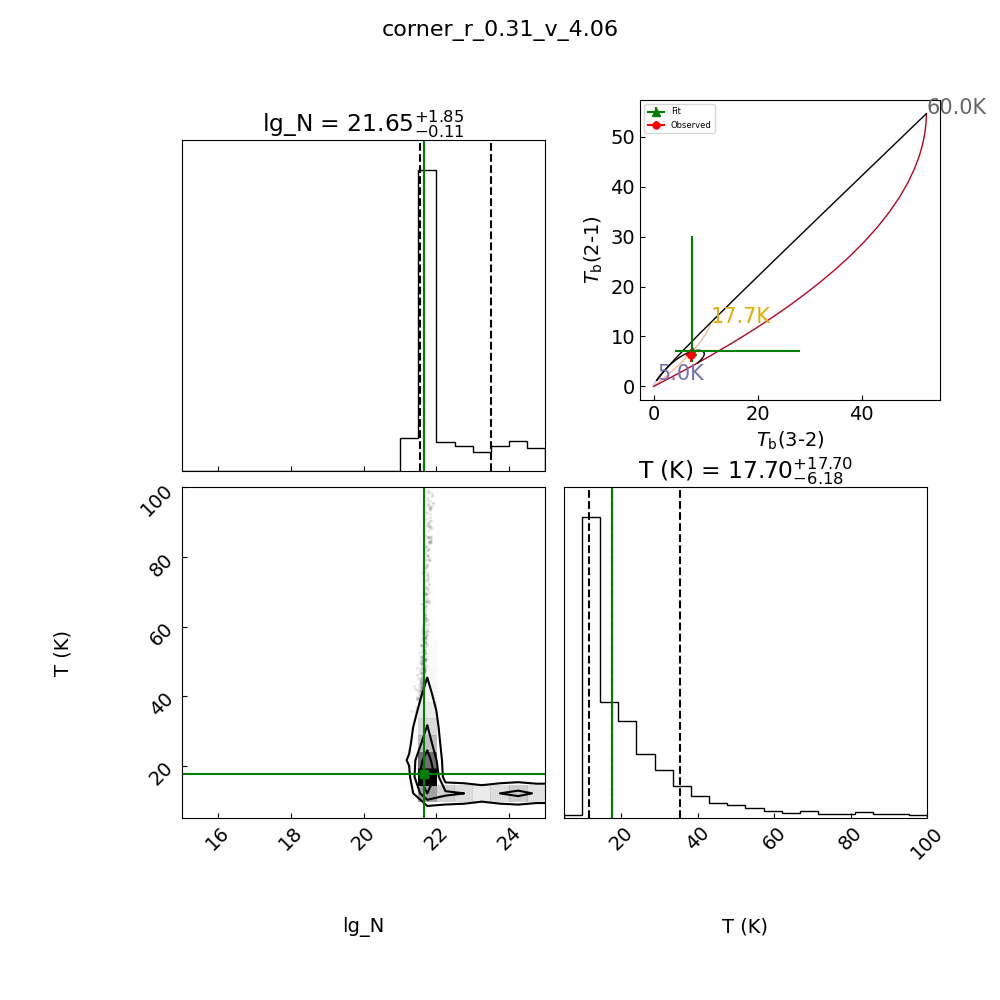

In [36]:
Texe_rs_empkep = []
Texe_upq_empkep = []
Texe_lq_empkep = []

Ncol_rs_empkep = []
Ncol_upq_empkep = []
Ncol_lq_empkep = []

plot_corner = True

np.random.seed(41)

N_conv_fraction = 1.e-7
lg_n_bounds = [15.,25.]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0],T_bounds[-1])

op_dir_label = "redshifted_points_empkep_test"

ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_sur_pt_rs"][15:16], Tb_df_b6["Tb_sur_pt_rs"][15:16], 
                          pv_b6.r_as_rs[15:16], pv_b6.v_rot_redshifted[15:16]):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt((0.1*Tb7)**2 + 1.08**2), 
                                                    s2=np.sqrt((0.1*Tb6)**2 + 0.49**2), 
                                                estimator='mcmc', initial_params = [lg_n_init, T_init], 
                                                bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                initial_scatter = 0.1, args= None,
                                                nwalkers = 20, n_steps = 10000, burn_in = 2000, thin_by = 50, return_flat= True,
                                                intensity_model = lte_model, plot_chain = True, 
                                                r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),"chains",op_dir_label),
                                                show_chains = False)
                
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep.append(T_qtls[0])
    Texe_rs_empkep.append(T_qtls[1])
    Texe_upq_empkep.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep.append(Ncol_qtls[0])
    Ncol_rs_empkep.append(Ncol_qtls[1])
    Ncol_upq_empkep.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt,ax_lt = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        #plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [ ]:
# Calculate errorbars

T_err_empkep_rs = [np.array(Texe_rs_empkep)-np.array(Texe_lq_empkep),np.array(Texe_upq_empkep)-np.array(Texe_rs_empkep)] #[tl,tu] for tl,tu in zip(

N_err_empkep_rs = [np.array(Ncol_rs_empkep)-np.array(Ncol_lq_empkep), np.array(Ncol_upq_empkep)-np.array(Ncol_rs_empkep)]

In [ ]:
results_data = {"r_empkep_rs": pv_b6.r_as_rs,
        "Tb7_empkep_rs" : Tb_df_b7["Tb_on_point_rs"], "Tb6_empkep_rs" : Tb_df_b6["Tb_on_point_rs"],
        "Texe_rs_empkep" : Texe_rs_empkep, "Texe_err_rs_empkep" : np.array(T_err_empkep_rs).T.tolist(),
        "Ncol_rs_empkep" : Ncol_rs_empkep, "Ncol_err_rs_empkep" : np.array(N_err_empkep_rs).T.tolist()
        }

print(np.shape(T_err_empkep_rs))
print(len(pv_b6.r_as_rs), len(Tb_df_b7["Tb_on_point_rs"]), len(Tb_df_b6["Tb_on_point_rs"]), len( Ncol_rs_empkep),
      len(N_err_empkep_rs))
results_df = pd.DataFrame(data = results_data)

respath = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
results_df.to_csv(path_or_buf= os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv"))

(2, 26)
26 26 26 26 2


#### Visualize results

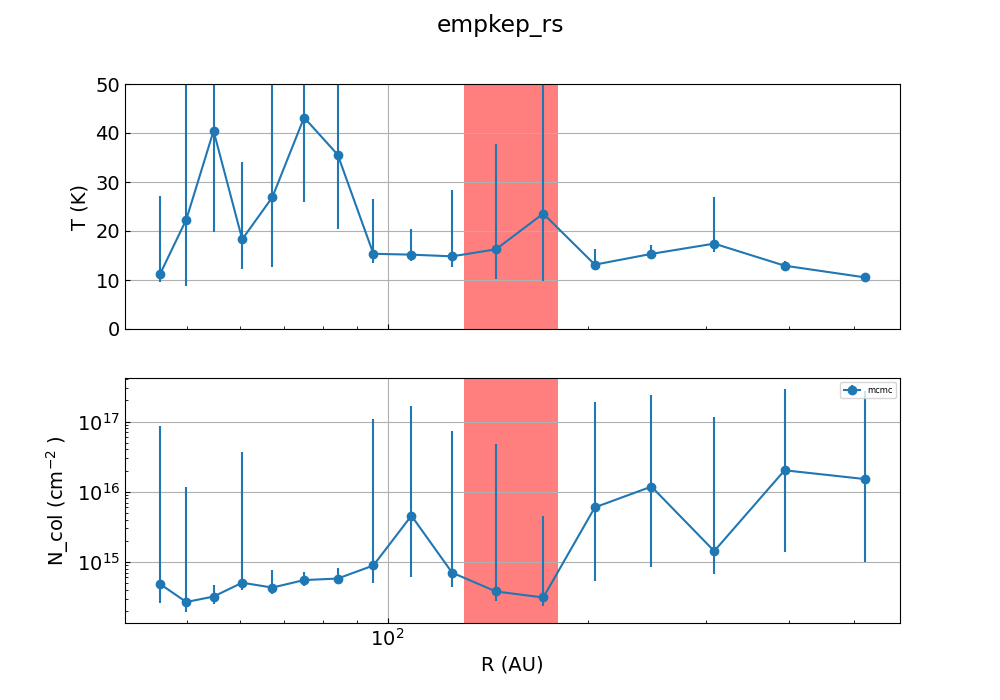

In [ ]:
vis_results_fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)

acceptable_r_range = [0.3, 5.0]

ftd_r_as_rs, ftd_Texe_rs_empkep, ftd_Terr_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Texe_rs_empkep, np.array(T_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[0].errorbar(np.array(ftd_r_as_rs)*140., ftd_Texe_rs_empkep, yerr=np.array(ftd_Terr_rs_empkep).T, marker='o', label = 'mcmc')
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,50)
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[1].legend(prop={'size': 6})

ftd_r_as_rs, ftd_Ncol_rs_empkep, ftd_N_err_rs_empkep = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep, np.array(N_err_empkep_rs).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs)*140., np.array(ftd_Ncol_rs_empkep)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep).T*N_conv_fraction, marker='o', label = 'mcmc')

axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].grid(True)
axes[1].legend(prop={'size': 6})
axes[1].set_xlabel("R (AU)")

vis_results_fig.suptitle("empkep_rs")

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)

if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')

### Temperature estimation (fix r)

#### Read the Data

In [6]:
# Read b7 data
pv_b7 = pv_analyze(pv_path='uid___A002_Xb5ee5a_X288a.ms.split.cal.l1489irs.spw3.cvel_chavg2.cube.clean_2_6_8_05.image.pbcor.regridded.smoothened.PV_54_w1.fits',
                    is_Tb=True, v_sys=7.22) # V_sys - 7.22, 7.27 7.384
pv_b7.read_pv(print_details = True)


# Read band 6 data
pv_b6 = pv_analyze(pv_path='uid___A002_b_6.cal.l1489_irs.spw_1_7.line.cube.clean.c_baseline_0.image.pbcor.Regridded.Smoothened.PV_54_w1.fits',
                    is_Tb=True, v_sys=7.22)
pv_b6.read_pv(print_details = True)



Convert frequency to velocity
 rms = 3.56e-02 Jy beam$^-1$
 rms = 1.11 K
Convert frequency to velocity
 rms = 7.37e-03 Jy beam$^-1$
 rms = 0.52 K


In [7]:
# define fix r points
# Get equidistance points

r_au_empkep_rs_fix_r = np.arange(start=42., step=42., stop=840.)
r_au_empkep_bs_fix_r = -r_au_empkep_rs_fix_r

v_100 = 3.2 #kmps # idpft-2.674 # JS- 3.2 # newft 2.842

v_rot_empkep_rs_fix_r =  emp_kep_r(r=r_au_empkep_rs_fix_r, r_b=100., v_100=v_100)
v_rot_empkep_bs_fix_r = - v_rot_empkep_rs_fix_r

plot_points = [r_au_empkep_rs_fix_r, v_rot_empkep_rs_fix_r, r_au_empkep_bs_fix_r, v_rot_empkep_bs_fix_r]

In [8]:
# Evaluate empirical keplerian curve function
r_rs_func = np.arange(start=1., step=0.5, stop=840.)   # Note that this is in AU
v_rs_func = emp_kep_r(r=r_rs_func, r_b=100., v_100=v_100)

r_bs_func = -r_rs_func
v_bs_func = -v_rs_func

In [9]:
Tb_df_b7 = pv_b7.get_tb_on_curve(curve_function = plot_points, 
                                get_surrounding_pix = False, mode='vals',
                                num_pix = 3)
Tb_df_b6 = pv_b6.get_tb_on_curve(curve_function = plot_points, 
                                    get_surrounding_pix = False, mode='vals',
                                    num_pix = 3)

#### Data Visualization

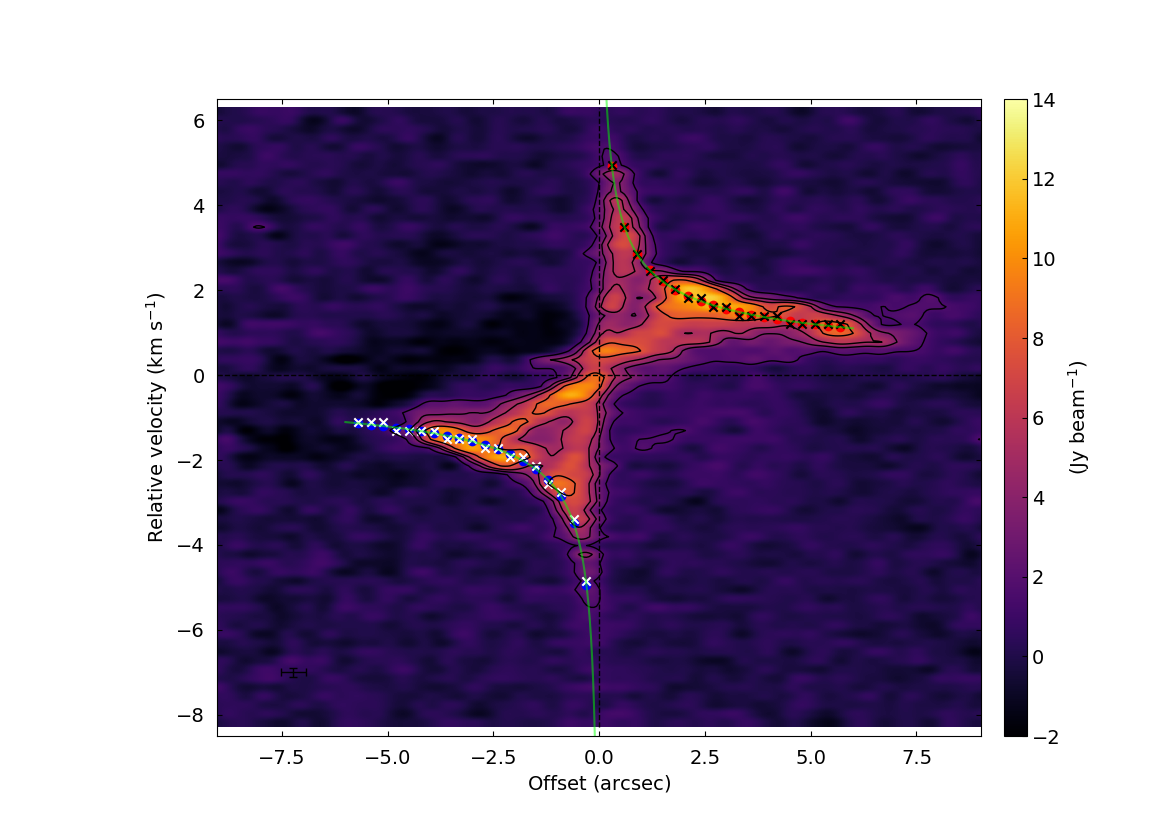

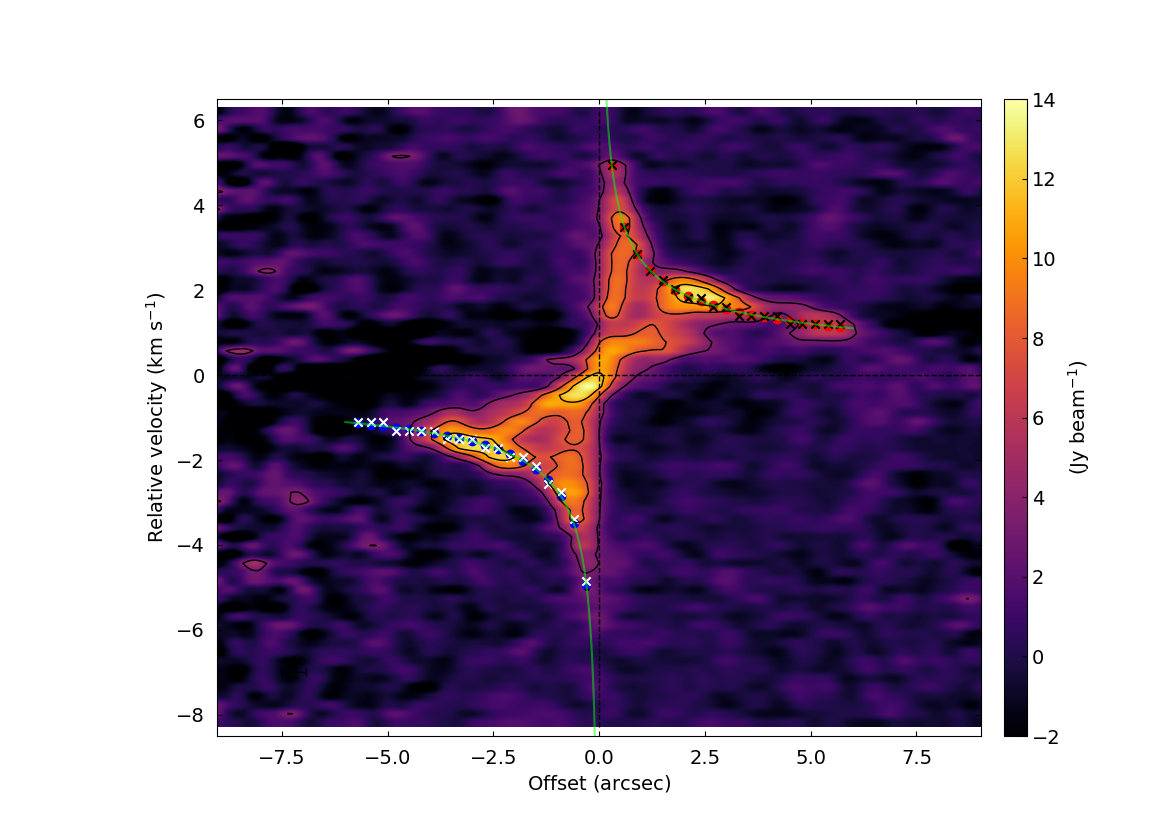

In [10]:

pv_dia6 = pv_b6.plot_pv(plot_curve=True)
pv_dia6[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia6[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

pv_dia7 = pv_b7.plot_pv(plot_curve=True)
pv_dia7[0].plot(r_rs_func/140.,v_rs_func,color = 'lime', alpha = 0.5)
pv_dia7[0].plot(r_bs_func/140.,v_bs_func,color = 'lime', alpha = 0.5)

#### T estimation loop (fix r)

In [11]:
# Initiate LTE model
lte_model = LTEAnalysis()
lte_model.read_lamda_moldata('c18o')

estimating for r = 3.000e-01 arcsec, v =  4.94 Kmps , Tb7 = 5.0, Tb6 = 1.9


100%|██████████| 9000/9000 [01:06<00:00, 135.29it/s]


dtauv_dT =  3.7822325348120175e-07
dtauv_dT =  1.1545986054679343e-07
Tb7_dIv_dN = 2.30e-14, Tb6_dIv_dN = 1.45e-14
Tb7_dIv_dT = 0.08, Tb6_dIv_dT = 0.05
Ncols and lgNcols up 1.84e+14, lgNc = 1.43e+01
Ncols and lgNcols med 1.50e+14, lgNc = 1.42e+01
Ncols and lgNcols dwn 1.17e+14, lgNc = 1.41e+01
del T -> + 10.77, - 15.03
del N -> + 3.40e+13, - 3.27e+13
Error propagation results:
$\Delta Tb_{6}$ [[0.88616877 0.72893763]]
$\Delta Tb_{7}$ [[1.47208762 1.19758012]]


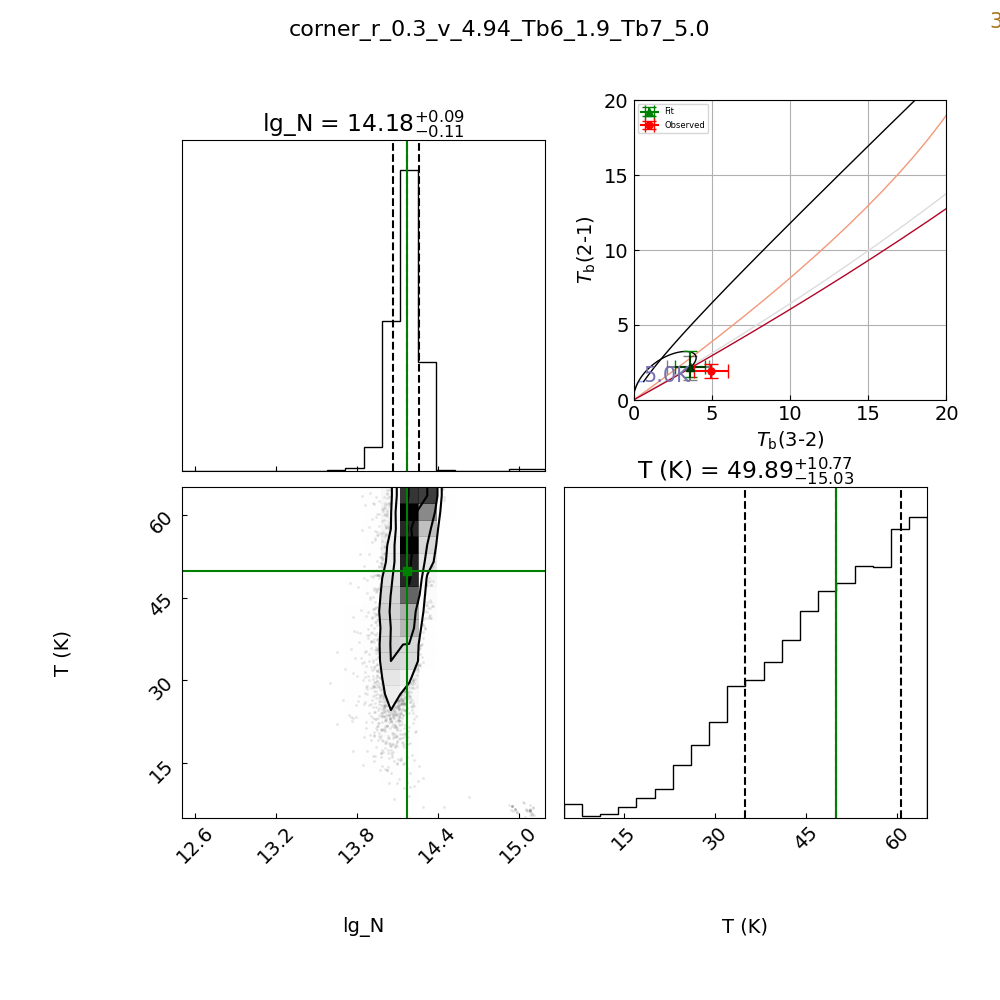

estimating for r = 6.000e-01 arcsec, v =  3.49 Kmps , Tb7 = 8.9, Tb6 = 6.3


100%|██████████| 9000/9000 [01:13<00:00, 123.02it/s]


dtauv_dT =  2.7610544266255607e-06
dtauv_dT =  9.00367498091388e-07
Tb7_dIv_dN = 1.93e-14, Tb6_dIv_dN = 1.42e-14
Tb7_dIv_dT = 0.27, Tb6_dIv_dT = 0.17
Ncols and lgNcols up 4.55e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.04e+14, lgNc = 1.46e+01
Ncols and lgNcols dwn 3.63e+14, lgNc = 1.46e+01
del T -> + 13.22, - 11.14
del N -> + 5.18e+13, - 4.03e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.02496667 2.41916245]]
$\Delta Tb_{7}$ [[3.08300884 3.67819263]]


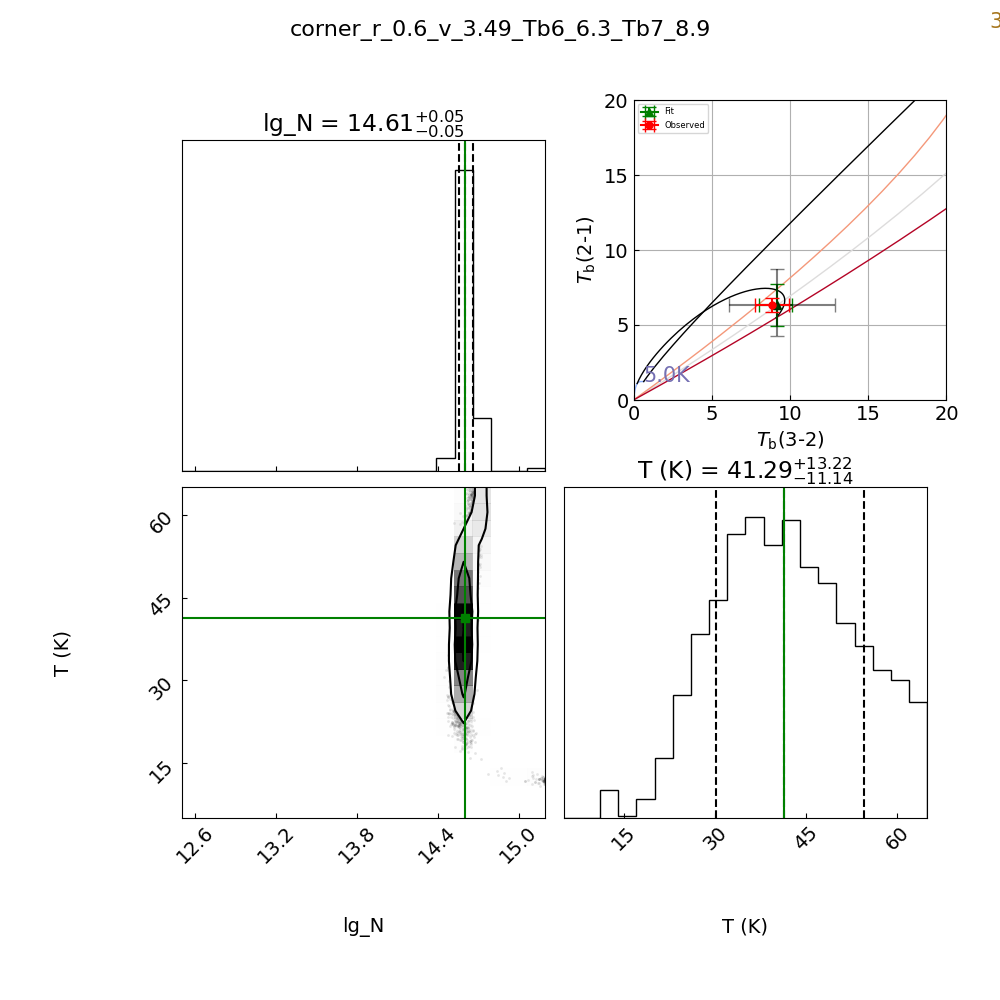

estimating for r = 9.000e-01 arcsec, v =  2.85 Kmps , Tb7 = 7.5, Tb6 = 5.2


100%|██████████| 9000/9000 [02:13<00:00, 67.29it/s]


dtauv_dT =  1.93610274501289e-06
dtauv_dT =  6.243912635774866e-07
Tb7_dIv_dN = 2.05e-14, Tb6_dIv_dN = 1.45e-14
Tb7_dIv_dT = 0.22, Tb6_dIv_dT = 0.14
Ncols and lgNcols up 3.78e+14, lgNc = 1.46e+01
Ncols and lgNcols med 3.30e+14, lgNc = 1.45e+01
Ncols and lgNcols dwn 2.91e+14, lgNc = 1.45e+01
del T -> + 13.73, - 12.65
del N -> + 4.86e+13, - 3.90e+13
Error propagation results:
$\Delta Tb_{6}$ [[1.83804622 2.02615109]]
$\Delta Tb_{7}$ [[2.85664155 3.14090956]]


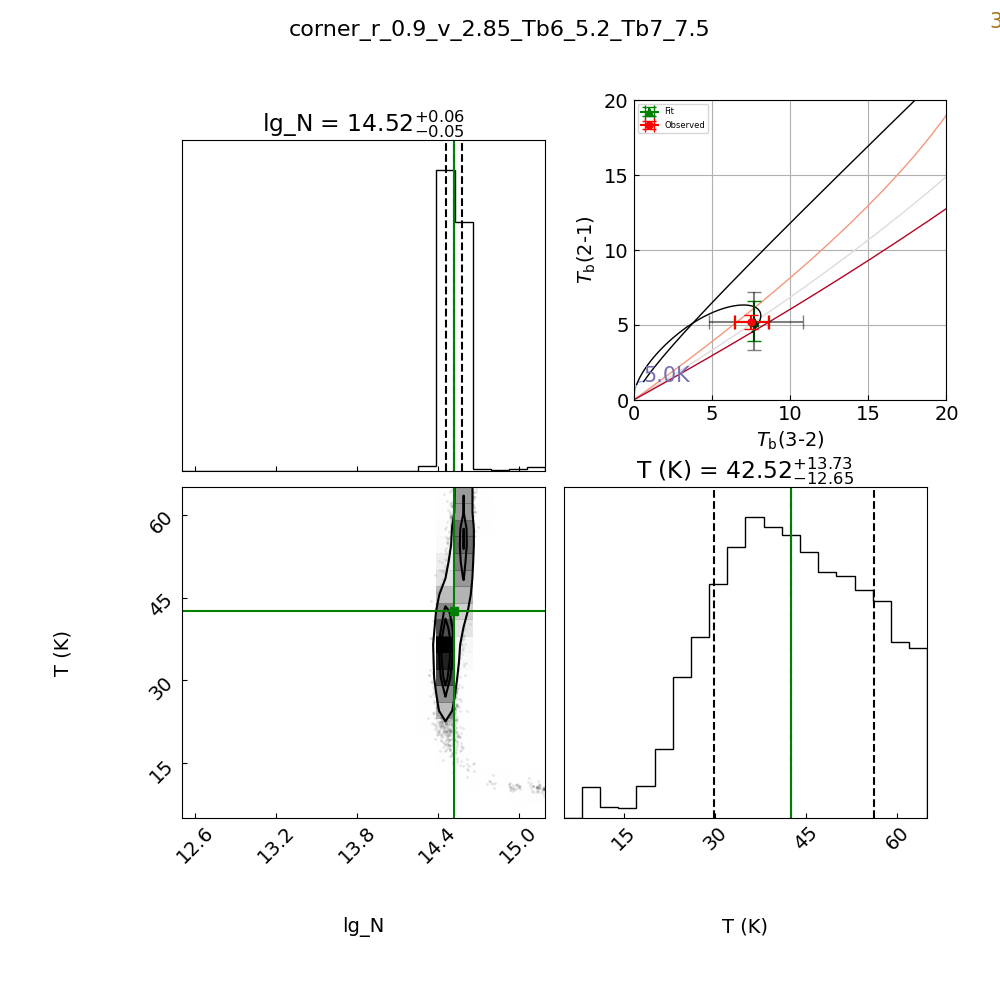

estimating for r = 1.200e+00 arcsec, v =  2.47 Kmps , Tb7 = 4.2, Tb6 = 3.9


100%|██████████| 9000/9000 [01:11<00:00, 125.33it/s]


dtauv_dT =  1.2207715516496443e-05
dtauv_dT =  4.8808807735631886e-06
Tb7_dIv_dN = 2.00e-14, Tb6_dIv_dN = 1.72e-14
Tb7_dIv_dT = 0.24, Tb6_dIv_dT = 0.18
Ncols and lgNcols up 2.59e+14, lgNc = 1.44e+01
Ncols and lgNcols med 2.12e+14, lgNc = 1.43e+01
Ncols and lgNcols dwn 1.80e+14, lgNc = 1.43e+01
del T -> + 18.05, - 11.24
del N -> + 4.69e+13, - 3.22e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.1392797  3.41451853]]
$\Delta Tb_{7}$ [[2.79622355 4.46852805]]


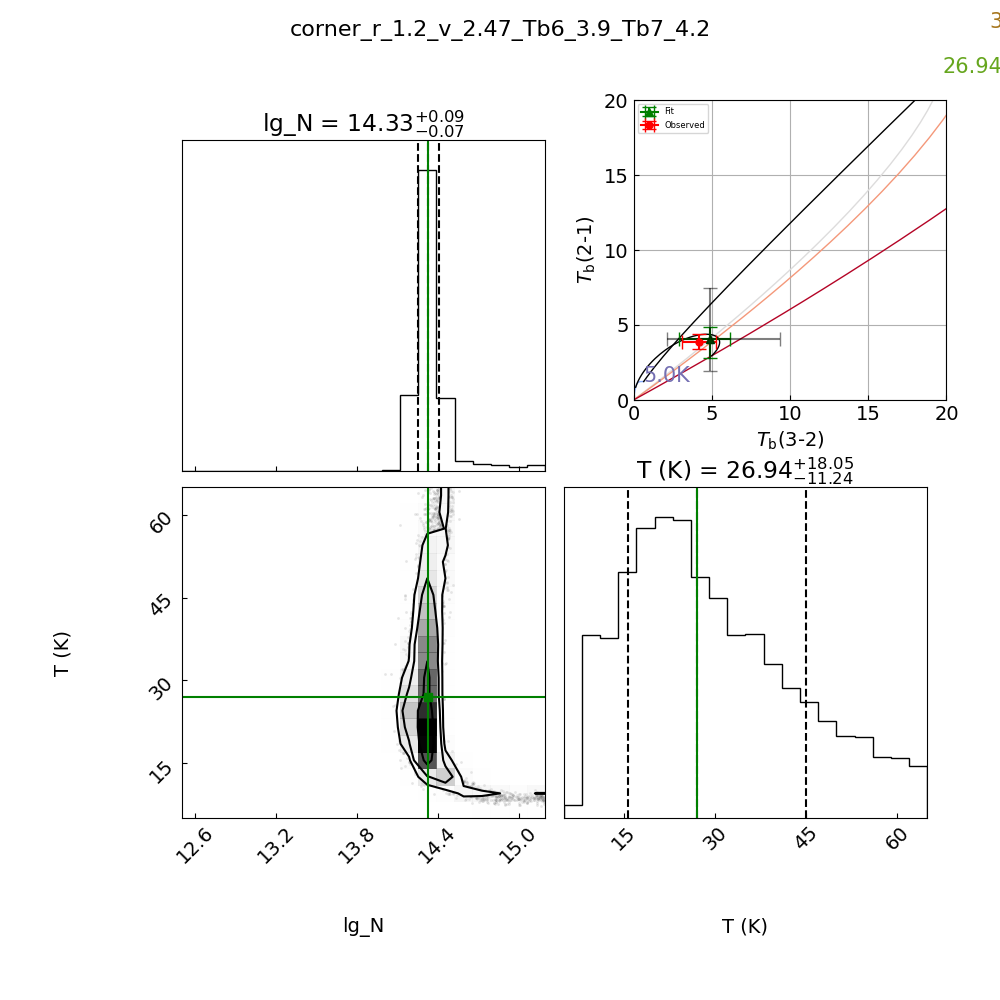

estimating for r = 1.500e+00 arcsec, v =  2.21 Kmps , Tb7 = 7.0, Tb6 = 6.8


100%|██████████| 9000/9000 [01:15<00:00, 119.25it/s]


dtauv_dT =  6.0713019710628596e-05
dtauv_dT =  2.7831914396314256e-05
Tb7_dIv_dN = 1.27e-14, Tb6_dIv_dN = 1.32e-14
Tb7_dIv_dT = 0.47, Tb6_dIv_dT = 0.41
Ncols and lgNcols up 5.16e+14, lgNc = 1.47e+01
Ncols and lgNcols med 4.00e+14, lgNc = 1.46e+01
Ncols and lgNcols dwn 3.59e+14, lgNc = 1.46e+01
del T -> + 7.93, - 6.41
del N -> + 1.16e+14, - 4.16e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.67145362 3.57656354]]
$\Delta Tb_{7}$ [[3.04299878 3.99020749]]


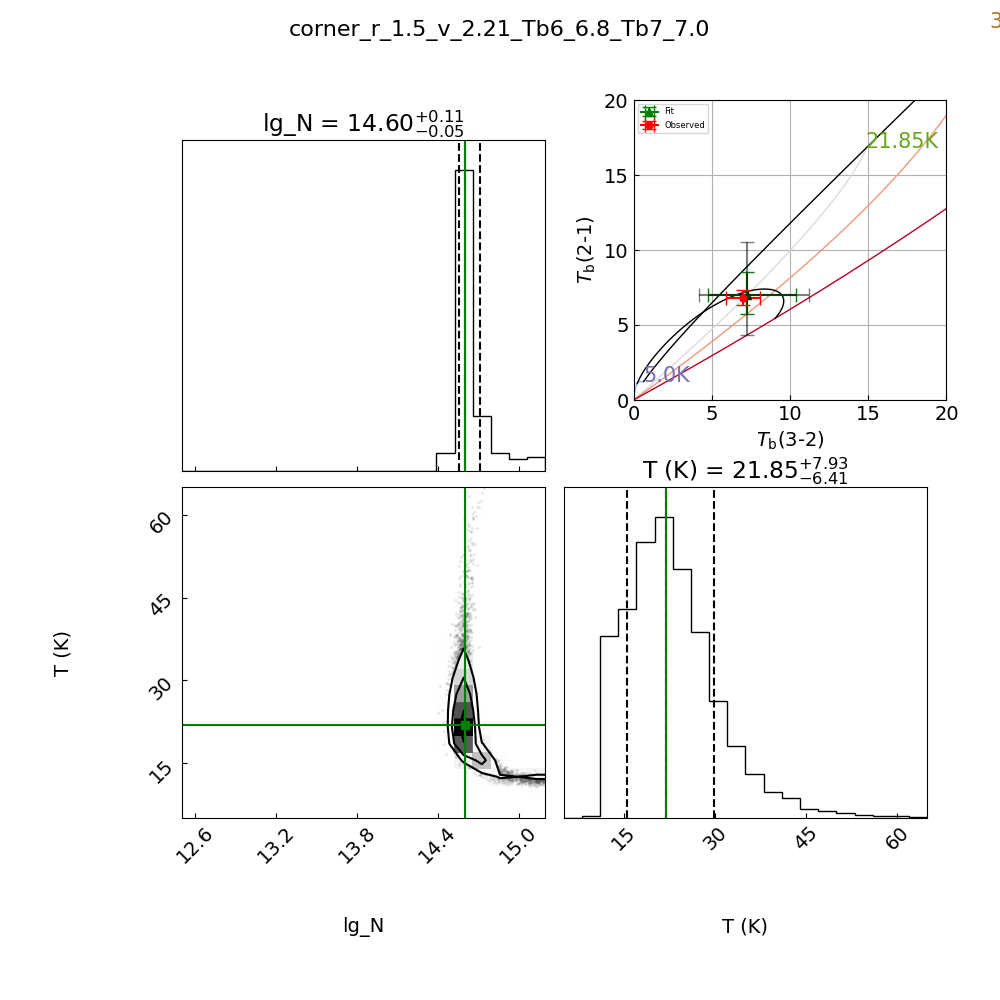

estimating for r = 1.800e+00 arcsec, v =  2.02 Kmps , Tb7 = 11.7, Tb6 = 10.2


100%|██████████| 9000/9000 [01:18<00:00, 115.32it/s]


dtauv_dT =  3.269474566368399e-05
dtauv_dT =  1.283338244410296e-05
Tb7_dIv_dN = 1.13e-14, Tb6_dIv_dN = 1.14e-14
Tb7_dIv_dT = 0.56, Tb6_dIv_dT = 0.45
Ncols and lgNcols up 7.23e+14, lgNc = 1.49e+01
Ncols and lgNcols med 6.61e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 6.16e+14, lgNc = 1.48e+01
del T -> + 6.28, - 4.94
del N -> + 6.13e+13, - 4.49e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.29028109 2.91899832]]
$\Delta Tb_{7}$ [[2.82662506 3.5977193 ]]


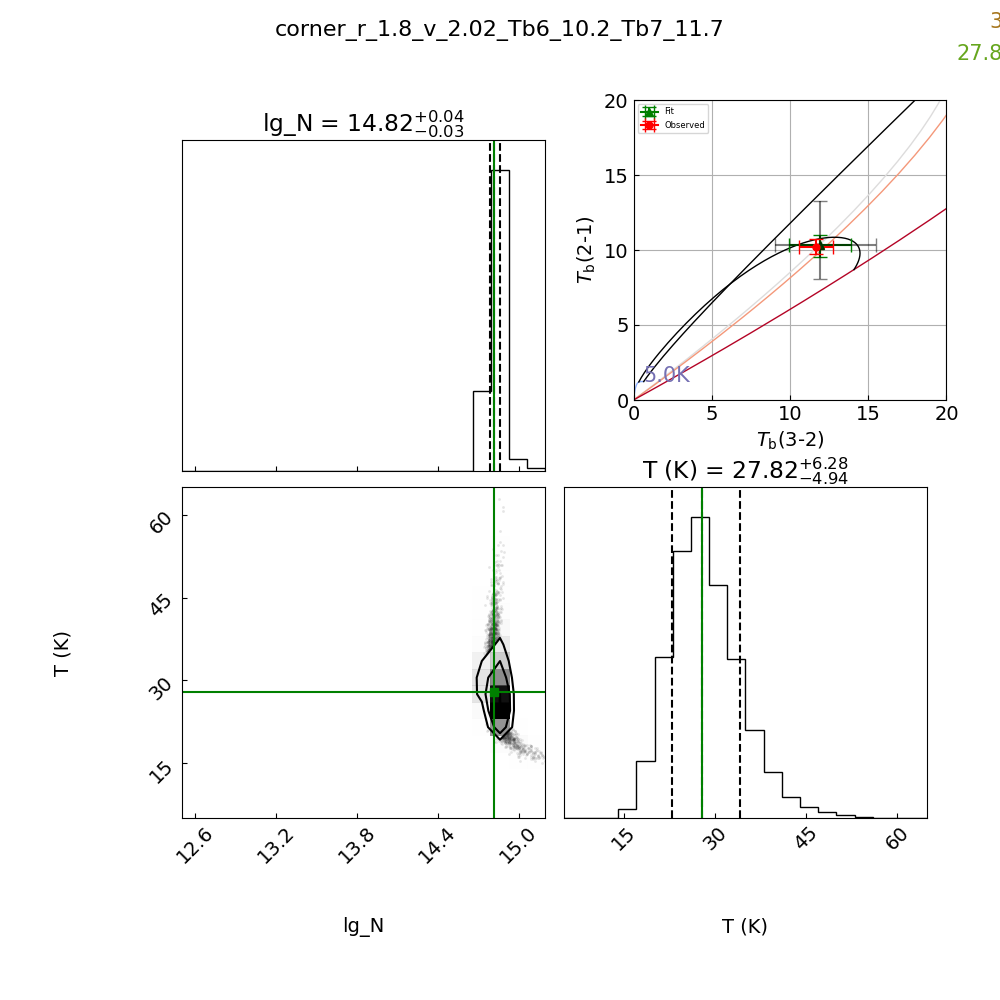

estimating for r = 2.100e+00 arcsec, v =  1.87 Kmps , Tb7 = 12.3, Tb6 = 11.6


100%|██████████| 9000/9000 [01:17<00:00, 115.41it/s]


dtauv_dT =  7.282234587355545e-05
dtauv_dT =  3.0824447002189713e-05
Tb7_dIv_dN = 7.69e-15, Tb6_dIv_dN = 8.71e-15
Tb7_dIv_dT = 0.68, Tb6_dIv_dT = 0.59
Ncols and lgNcols up 9.83e+14, lgNc = 1.50e+01
Ncols and lgNcols med 8.18e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 7.43e+14, lgNc = 1.49e+01
del T -> + 4.49, - 3.88
del N -> + 1.66e+14, - 7.50e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.38587594 3.02313163]]
$\Delta Tb_{7}$ [[2.70239522 3.31067068]]


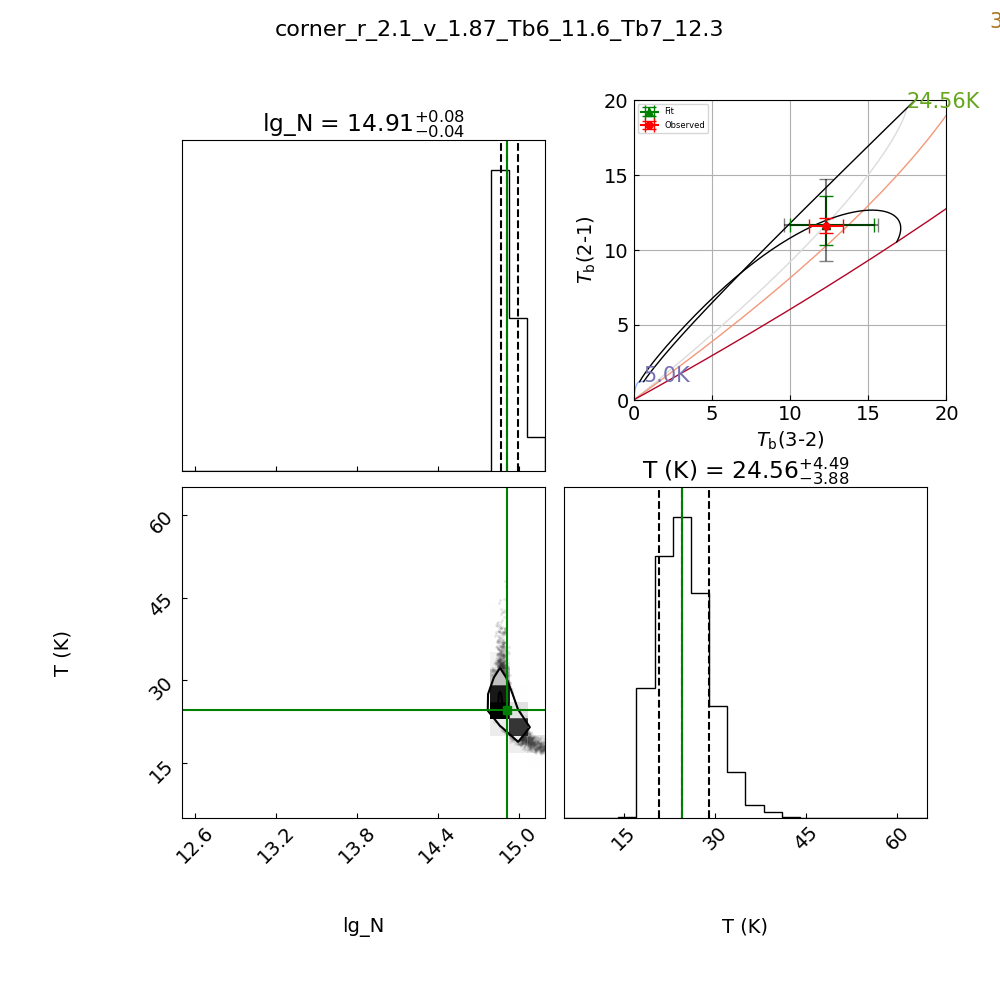

estimating for r = 2.400e+00 arcsec, v =  1.75 Kmps , Tb7 = 13.0, Tb6 = 11.9


100%|██████████| 9000/9000 [01:37<00:00, 92.42it/s] 


dtauv_dT =  5.2899072980152855e-05
dtauv_dT =  2.142902388698364e-05
Tb7_dIv_dN = 8.45e-15, Tb6_dIv_dN = 9.28e-15
Tb7_dIv_dT = 0.66, Tb6_dIv_dT = 0.56
Ncols and lgNcols up 9.50e+14, lgNc = 1.50e+01
Ncols and lgNcols med 8.27e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 7.65e+14, lgNc = 1.49e+01
del T -> + 4.75, - 4.17
del N -> + 1.23e+14, - 6.20e+13
Error propagation results:
$\Delta Tb_{6}$ [[2.39741334 2.88442214]]
$\Delta Tb_{7}$ [[2.8118205  3.31137343]]


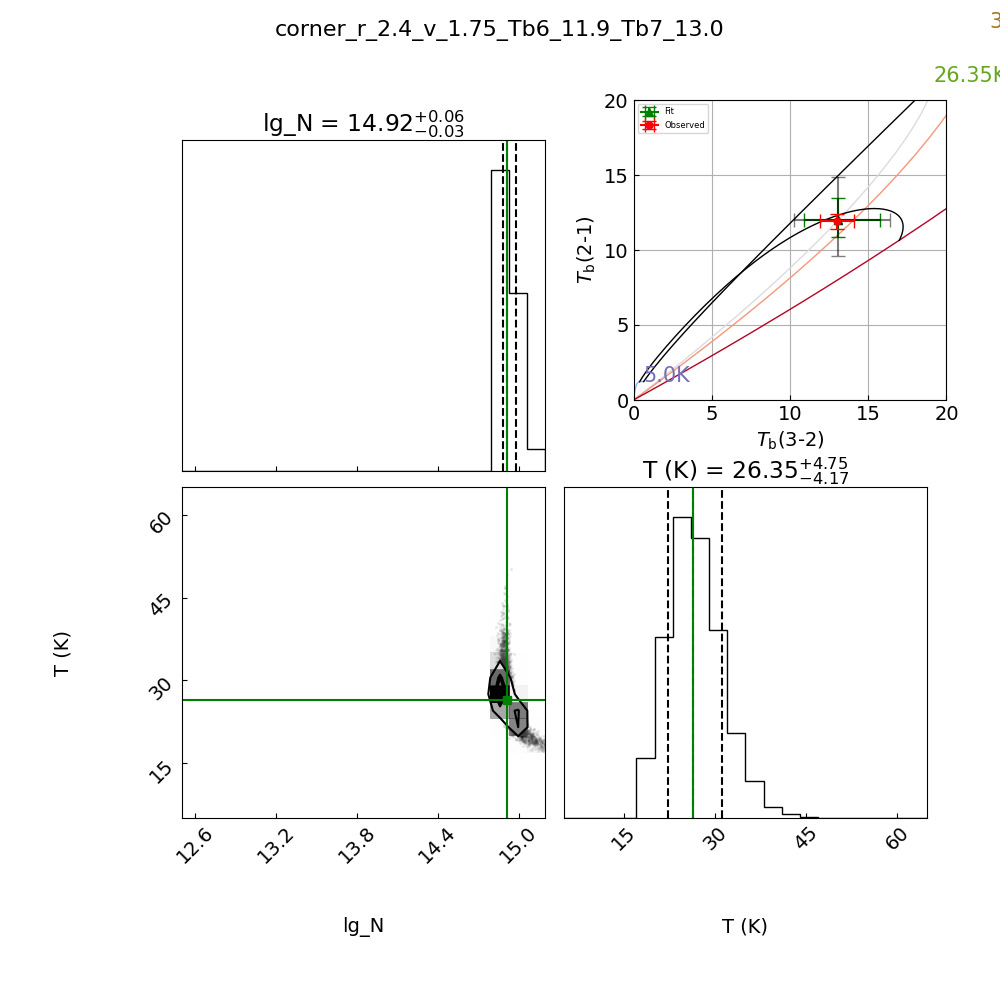

estimating for r = 2.700e+00 arcsec, v =  1.65 Kmps , Tb7 = 10.9, Tb6 = 11.4


100%|██████████| 9000/9000 [01:49<00:00, 82.52it/s] 


dtauv_dT =  0.0001871912451959241
dtauv_dT =  9.020488064200647e-05
Tb7_dIv_dN = 4.69e-15, Tb6_dIv_dN = 5.84e-15
Tb7_dIv_dT = 0.77, Tb6_dIv_dT = 0.73
Ncols and lgNcols up 1.24e+15, lgNc = 1.51e+01
Ncols and lgNcols med 9.19e+14, lgNc = 1.50e+01
Ncols and lgNcols dwn 7.69e+14, lgNc = 1.49e+01
del T -> + 3.74, - 2.43
del N -> + 3.22e+14, - 1.51e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.97710824 3.3109972 ]]
$\Delta Tb_{7}$ [[1.99167488 3.23939362]]


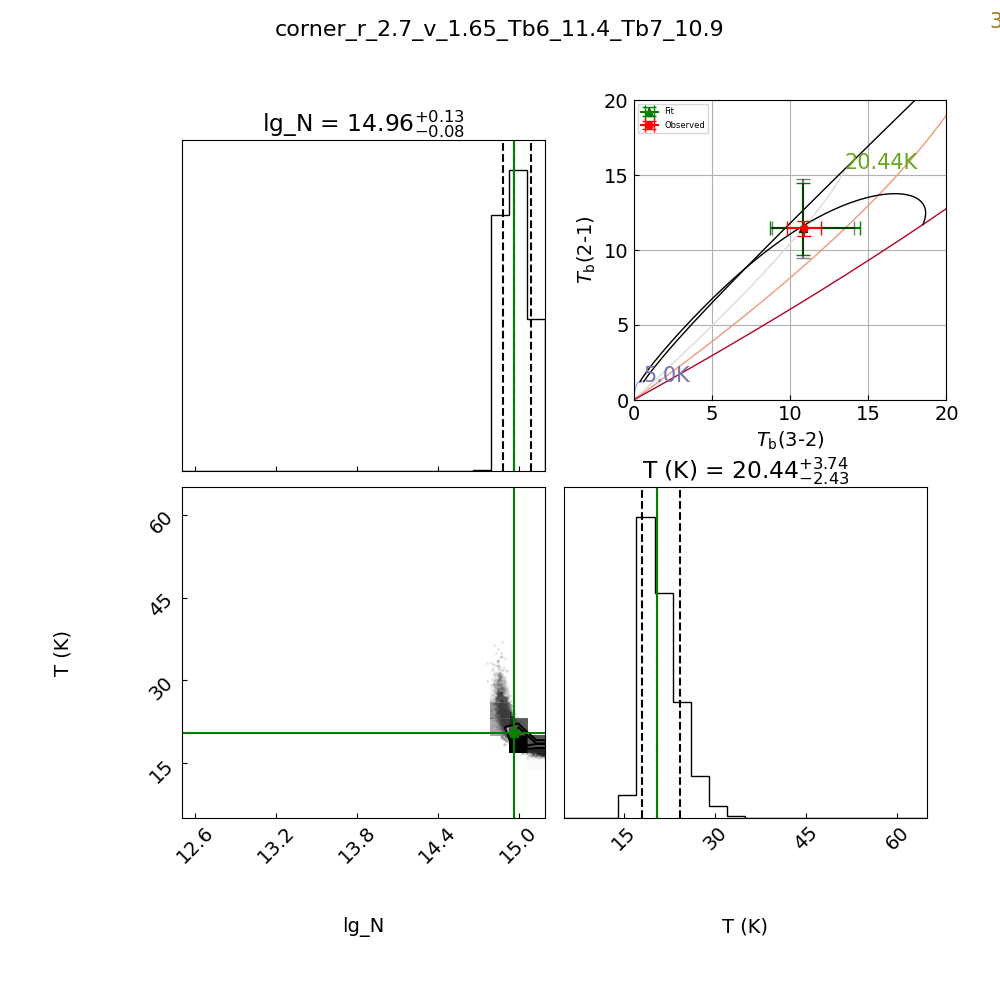

estimating for r = 3.000e+00 arcsec, v =  1.56 Kmps , Tb7 = 10.2, Tb6 = 11.1


100%|██████████| 9000/9000 [02:17<00:00, 65.43it/s]


dtauv_dT =  0.0002443181122235054
dtauv_dT =  0.00012317285457452871
Tb7_dIv_dN = 4.03e-15, Tb6_dIv_dN = 5.08e-15
Tb7_dIv_dT = 0.78, Tb6_dIv_dT = 0.76
Ncols and lgNcols up 1.28e+15, lgNc = 1.51e+01
Ncols and lgNcols med 9.39e+14, lgNc = 1.50e+01
Ncols and lgNcols dwn 7.56e+14, lgNc = 1.49e+01
del T -> + 3.48, - 2.02
del N -> + 3.42e+14, - 1.83e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.79476724 3.16200341]]
$\Delta Tb_{7}$ [[1.74145054 3.04547195]]


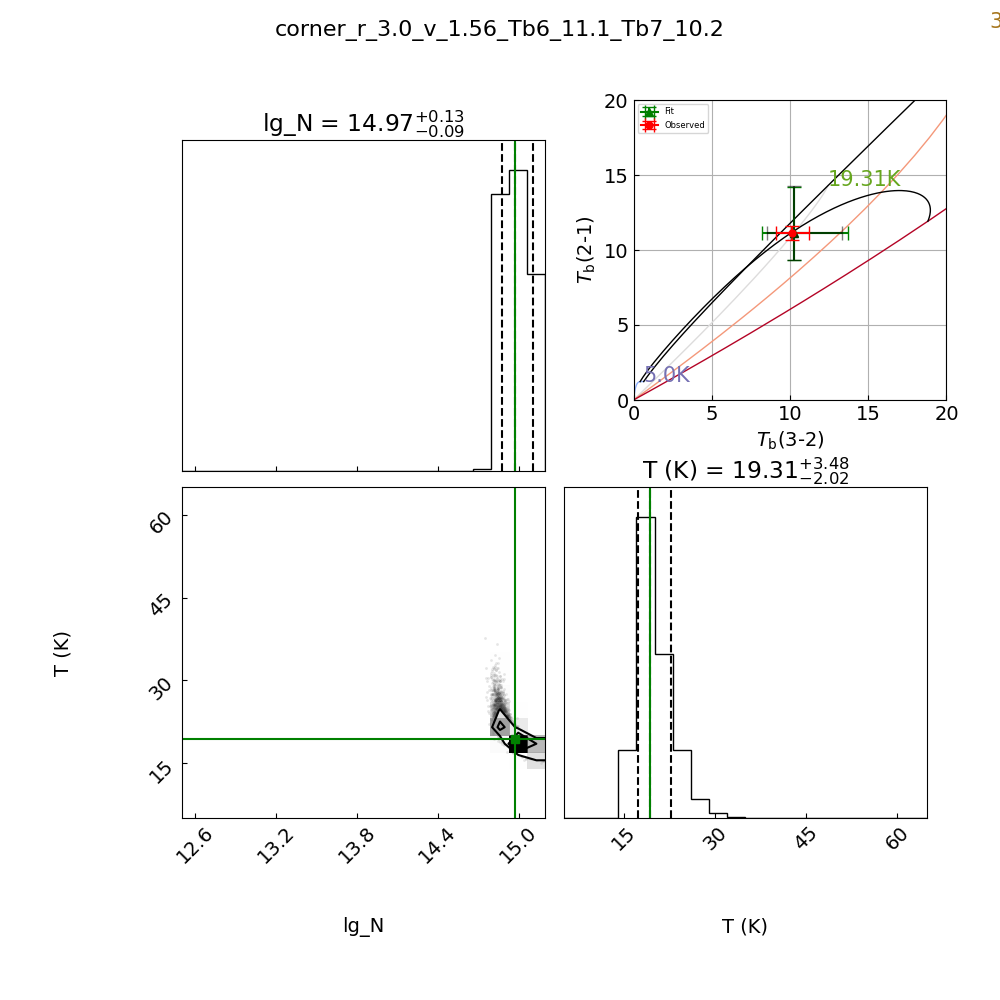

estimating for r = 3.300e+00 arcsec, v =  1.49 Kmps , Tb7 = 5.5, Tb6 = 9.9


100%|██████████| 9000/9000 [02:14<00:00, 67.04it/s]


dtauv_dT =  0.0007209002057645971
dtauv_dT =  0.0004496432443268395
Tb7_dIv_dN = 1.81e-15, Tb6_dIv_dN = 2.10e-15
Tb7_dIv_dT = 0.83, Tb6_dIv_dT = 0.87
Ncols and lgNcols up 1.40e+15, lgNc = 1.51e+01
Ncols and lgNcols med 1.09e+15, lgNc = 1.50e+01
Ncols and lgNcols dwn 8.09e+14, lgNc = 1.49e+01
del T -> + 1.35, - 0.82
del N -> + 3.16e+14, - 2.77e+14
Error propagation results:
$\Delta Tb_{6}$ [[0.9209614 1.3544668]]
$\Delta Tb_{7}$ [[0.84249021 1.25666035]]


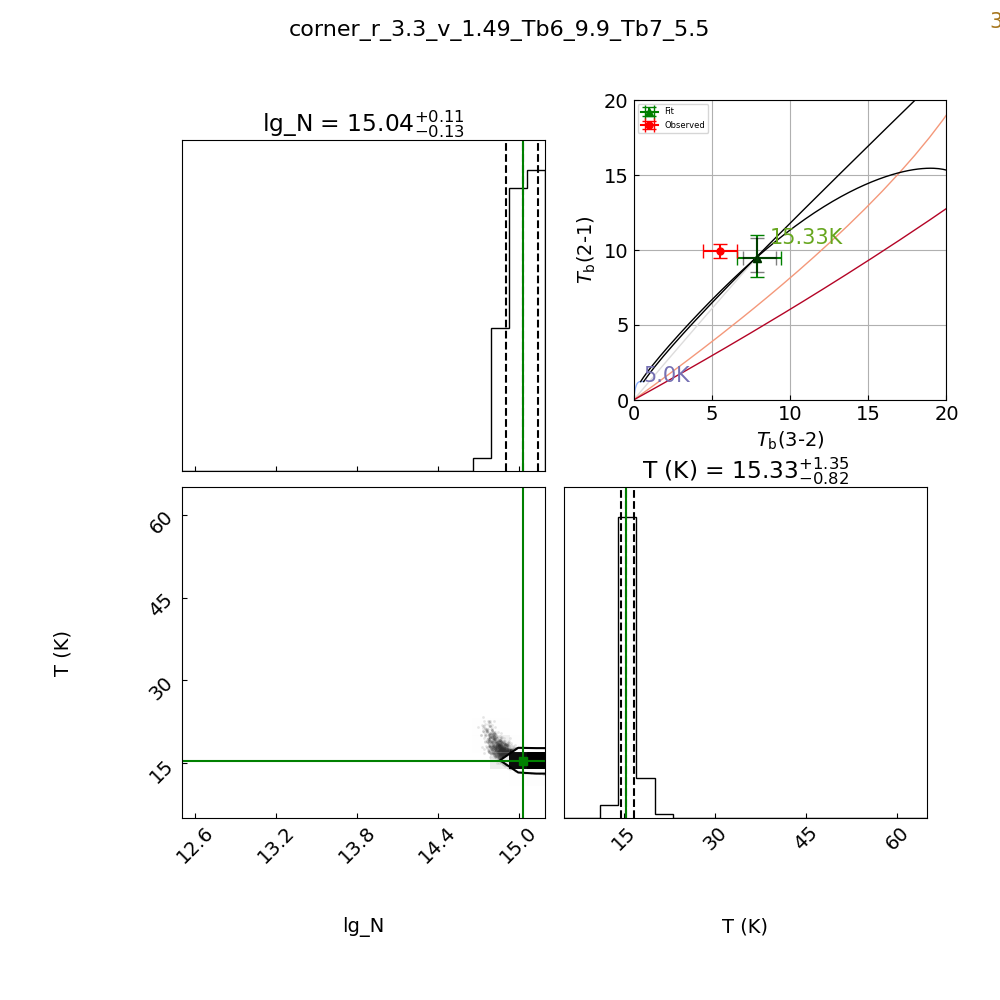

estimating for r = 3.600e+00 arcsec, v =  1.43 Kmps , Tb7 = 5.9, Tb6 = 9.8


100%|██████████| 9000/9000 [01:16<00:00, 117.05it/s]


dtauv_dT =  0.0006809857545121254
dtauv_dT =  0.0004234972045299584
Tb7_dIv_dN = 2.02e-15, Tb6_dIv_dN = 2.35e-15
Tb7_dIv_dT = 0.82, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 1.38e+15, lgNc = 1.51e+01
Ncols and lgNcols med 1.04e+15, lgNc = 1.50e+01
Ncols and lgNcols dwn 7.65e+14, lgNc = 1.49e+01
del T -> + 1.62, - 0.88
del N -> + 3.39e+14, - 2.73e+14
Error propagation results:
$\Delta Tb_{6}$ [[0.99509733 1.61130653]]
$\Delta Tb_{7}$ [[0.90736977 1.49295975]]


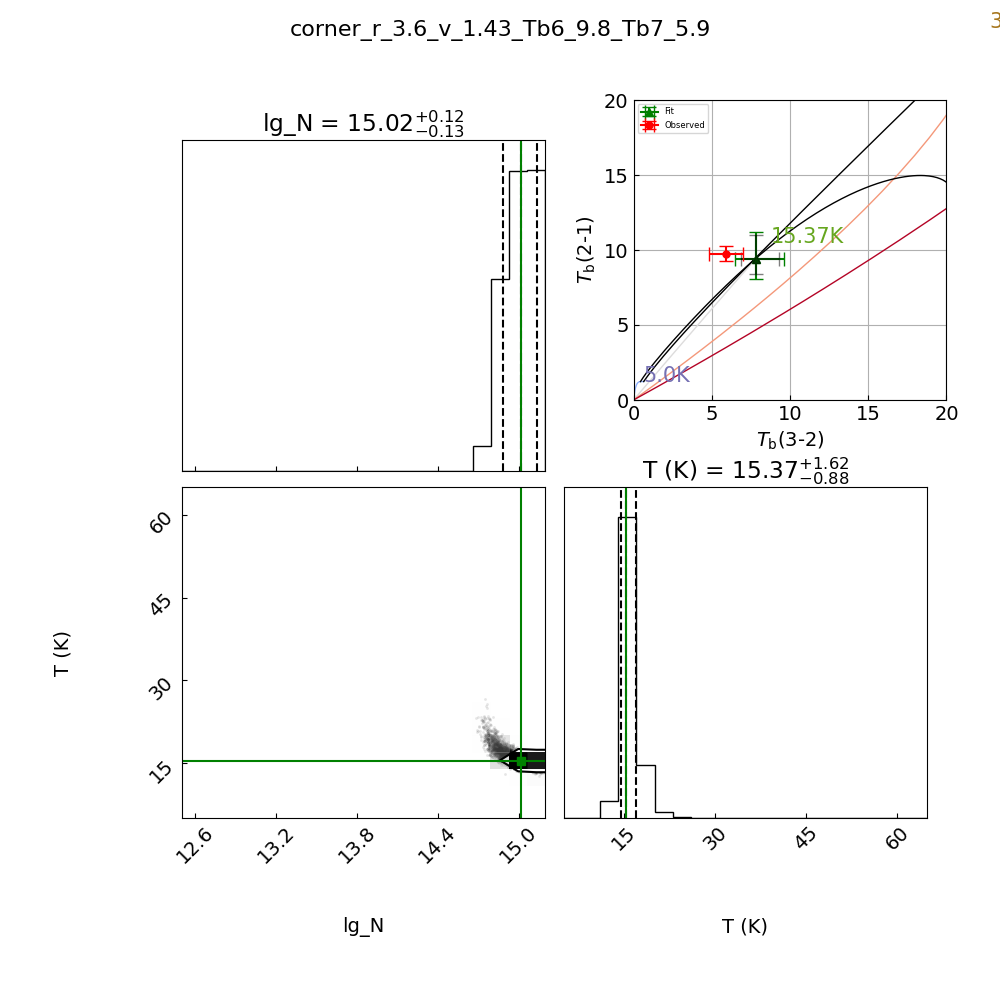

estimating for r = 3.900e+00 arcsec, v =  1.37 Kmps , Tb7 = 4.5, Tb6 = 8.6


100%|██████████| 9000/9000 [01:11<00:00, 126.43it/s]


dtauv_dT =  0.0008539368121505591
dtauv_dT =  0.0005856731701991453
Tb7_dIv_dN = 2.12e-15, Tb6_dIv_dN = 2.30e-15
Tb7_dIv_dT = 0.79, Tb6_dIv_dT = 0.86
Ncols and lgNcols up 1.31e+15, lgNc = 1.51e+01
Ncols and lgNcols med 9.27e+14, lgNc = 1.50e+01
Ncols and lgNcols dwn 6.53e+14, lgNc = 1.48e+01
del T -> + 1.65, - 0.89
del N -> + 3.78e+14, - 2.75e+14
Error propagation results:
$\Delta Tb_{6}$ [[0.99450403 1.66546066]]
$\Delta Tb_{7}$ [[0.91458713 1.53093762]]


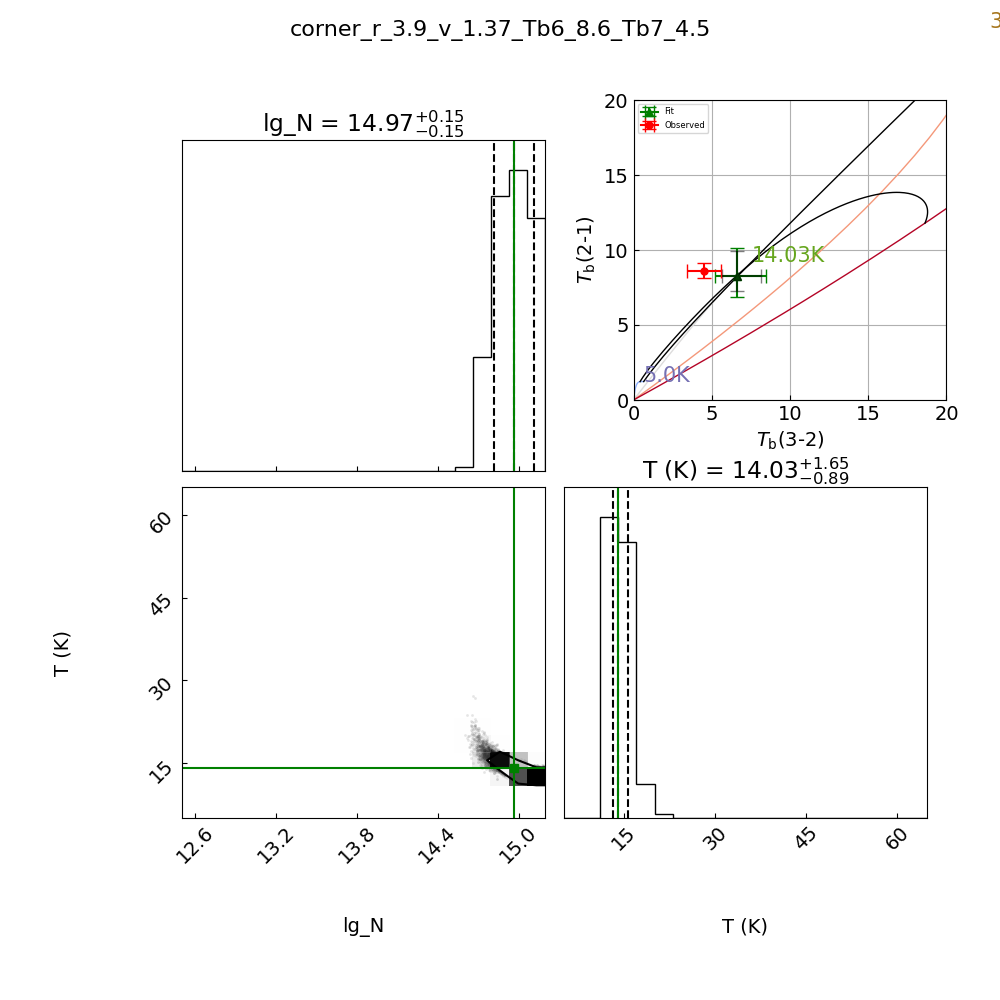

estimating for r = 4.200e+00 arcsec, v =  1.32 Kmps , Tb7 = 3.0, Tb6 = 7.9


100%|██████████| 9000/9000 [01:11<00:00, 125.62it/s]


dtauv_dT =  0.0010255488855288703
dtauv_dT =  0.0007680635016304655
Tb7_dIv_dN = 2.15e-15, Tb6_dIv_dN = 2.21e-15
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.85
Ncols and lgNcols up 1.25e+15, lgNc = 1.51e+01
Ncols and lgNcols med 8.55e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 5.98e+14, lgNc = 1.48e+01
del T -> + 1.52, - 0.84
del N -> + 4.00e+14, - 2.57e+14
Error propagation results:
$\Delta Tb_{6}$ [[0.91150686 1.56902261]]
$\Delta Tb_{7}$ [[0.84216393 1.44050702]]


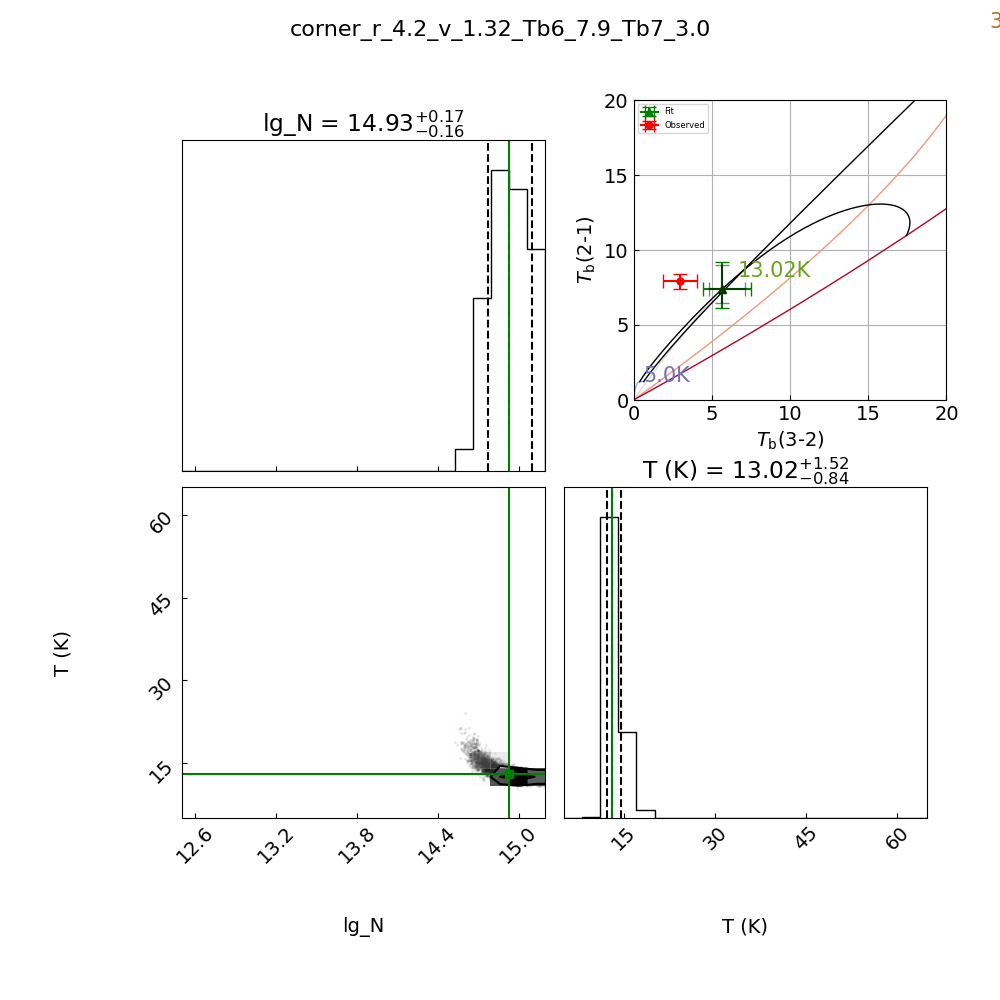

estimating for r = 4.500e+00 arcsec, v =  1.27 Kmps , Tb7 = 2.3, Tb6 = 5.5


100%|██████████| 9000/9000 [01:04<00:00, 139.46it/s]


dtauv_dT =  0.0010681452304349191
dtauv_dT =  0.000985471390163279
Tb7_dIv_dN = 3.34e-15, Tb6_dIv_dN = 3.70e-15
Tb7_dIv_dT = 0.60, Tb6_dIv_dT = 0.76
Ncols and lgNcols up 1.02e+15, lgNc = 1.50e+01
Ncols and lgNcols med 5.35e+14, lgNc = 1.47e+01
Ncols and lgNcols dwn 3.29e+14, lgNc = 1.45e+01
del T -> + 3.03, - 1.20
del N -> + 4.87e+14, - 2.06e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.19315083 2.93558928]]
$\Delta Tb_{7}$ [[0.99890491 2.44723117]]


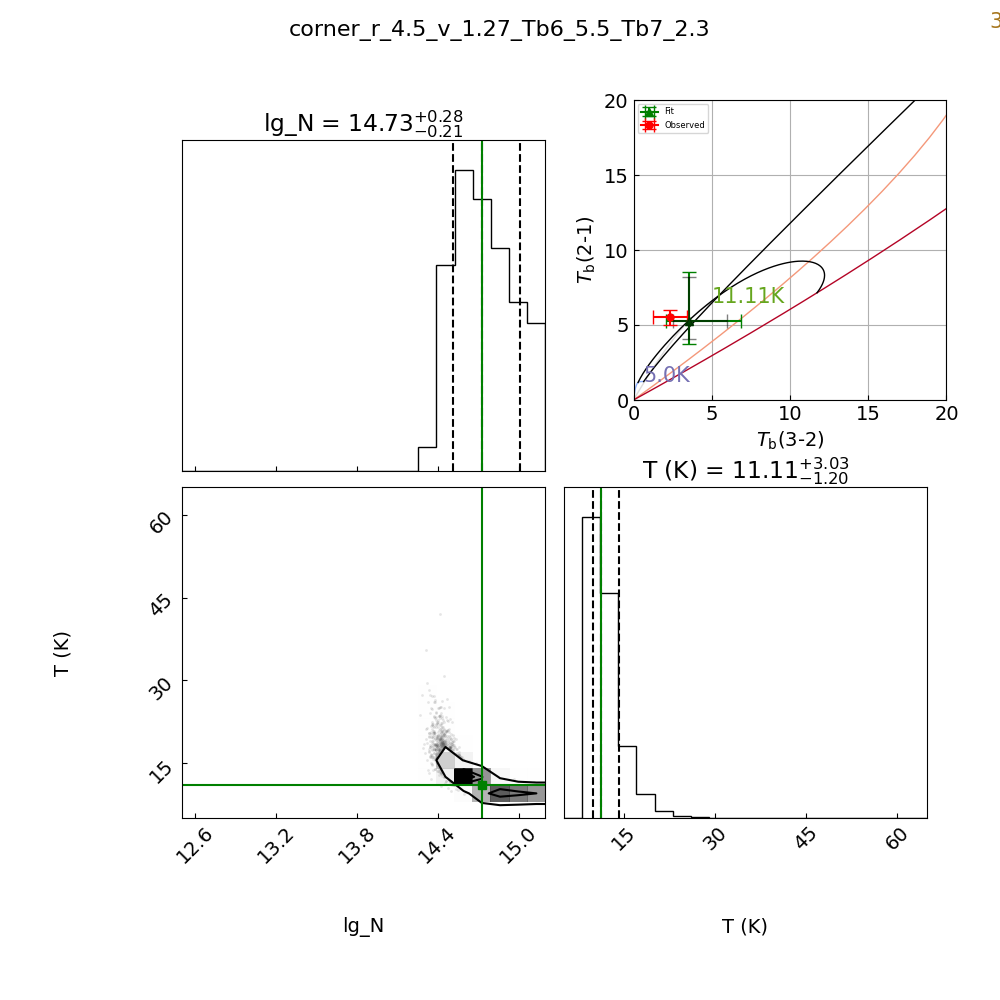

estimating for r = 4.800e+00 arcsec, v =  1.23 Kmps , Tb7 = 4.0, Tb6 = 6.3


100%|██████████| 9000/9000 [01:03<00:00, 142.67it/s]


dtauv_dT =  0.0007973843729102613
dtauv_dT =  0.0006294527596175682
Tb7_dIv_dN = 3.76e-15, Tb6_dIv_dN = 4.27e-15
Tb7_dIv_dT = 0.64, Tb6_dIv_dT = 0.76
Ncols and lgNcols up 1.08e+15, lgNc = 1.50e+01
Ncols and lgNcols med 5.76e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 3.75e+14, lgNc = 1.46e+01
del T -> + 3.65, - 1.44
del N -> + 5.02e+14, - 2.00e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.38725399 3.50354202]]
$\Delta Tb_{7}$ [[1.1944111  3.01579675]]


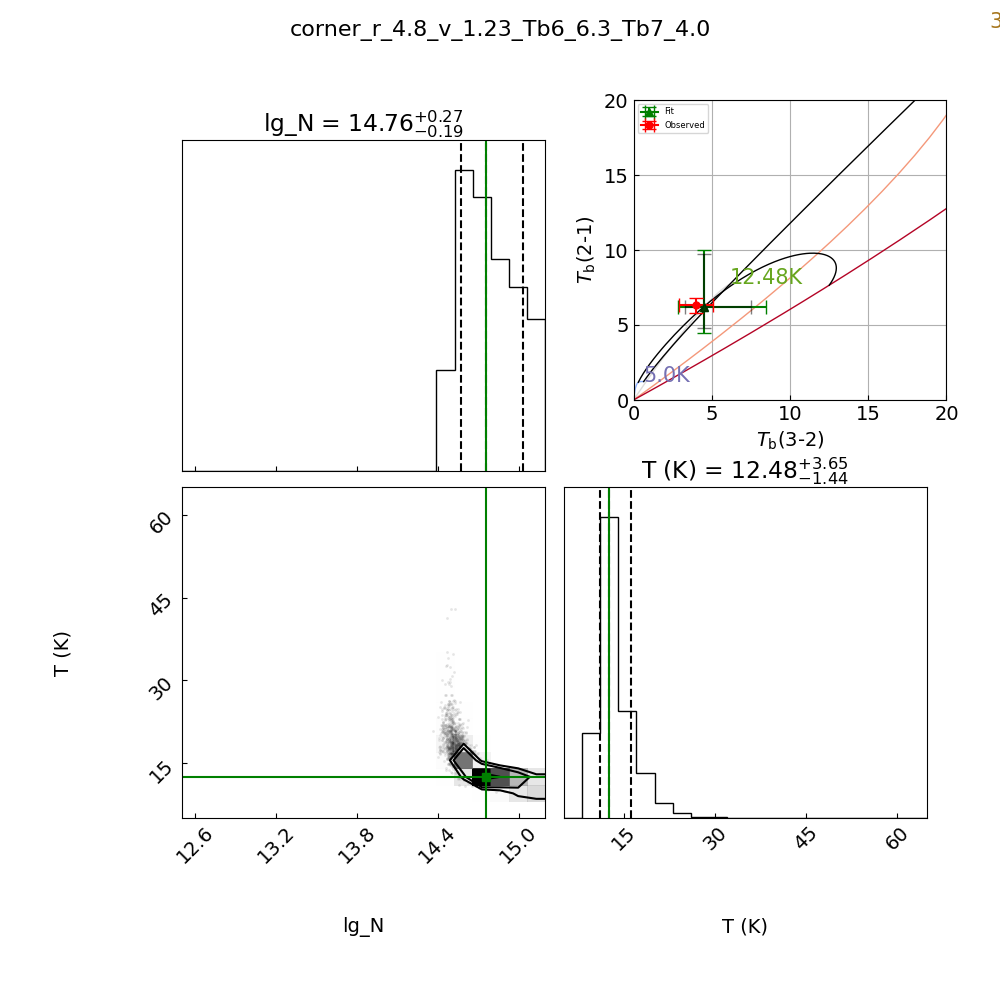

estimating for r = 5.100e+00 arcsec, v =  1.20 Kmps , Tb7 = 6.1, Tb6 = 7.6


100%|██████████| 9000/9000 [01:02<00:00, 144.58it/s]


dtauv_dT =  0.0004896551765735029
dtauv_dT =  0.00031844172038305235
Tb7_dIv_dN = 4.45e-15, Tb6_dIv_dN = 5.24e-15
Tb7_dIv_dT = 0.68, Tb6_dIv_dT = 0.74
Ncols and lgNcols up 1.11e+15, lgNc = 1.50e+01
Ncols and lgNcols med 6.35e+14, lgNc = 1.48e+01
Ncols and lgNcols dwn 4.55e+14, lgNc = 1.47e+01
del T -> + 4.23, - 1.92
del N -> + 4.75e+14, - 1.80e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.70462053 3.99667502]]
$\Delta Tb_{7}$ [[1.53820888 3.58228135]]


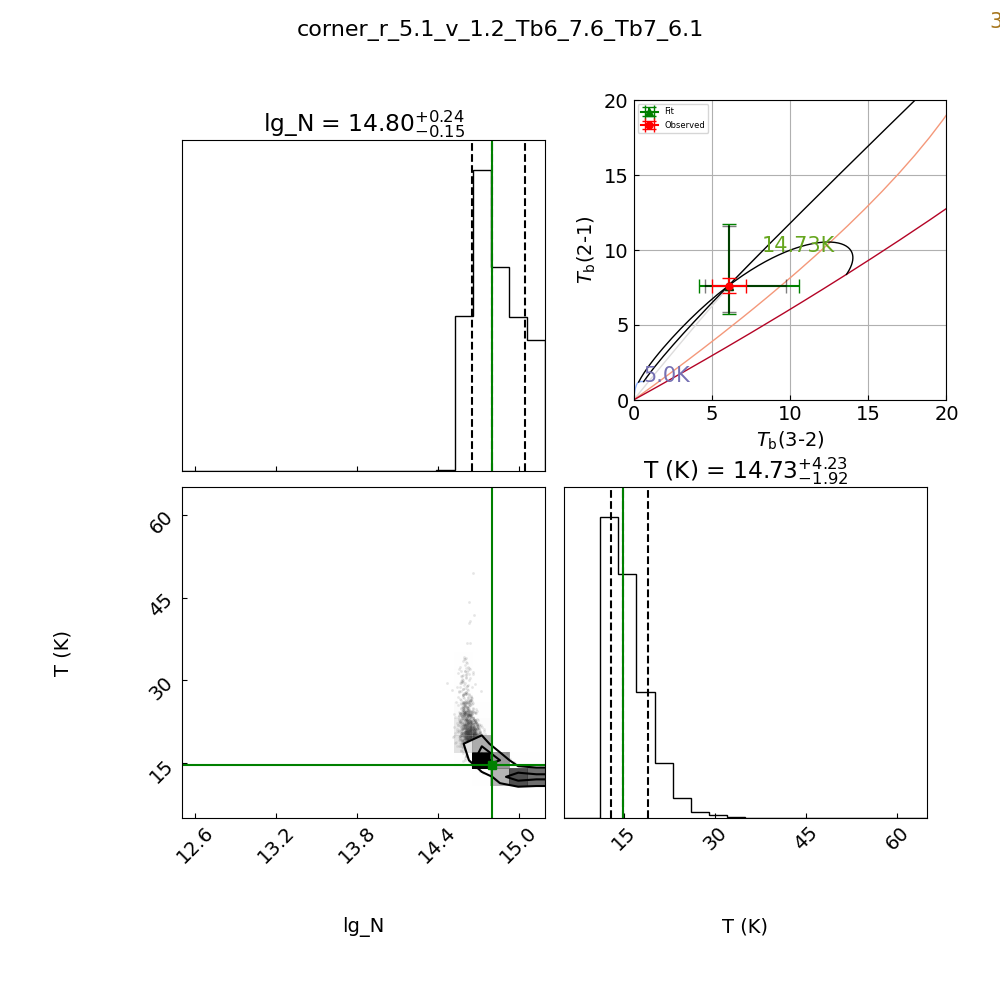

estimating for r = 5.400e+00 arcsec, v =  1.16 Kmps , Tb7 = 6.5, Tb6 = 8.8


100%|██████████| 9000/9000 [00:58<00:00, 154.50it/s]


dtauv_dT =  0.0005832707754380734
dtauv_dT =  0.0003686548142251002
Tb7_dIv_dN = 3.02e-15, Tb6_dIv_dN = 3.51e-15
Tb7_dIv_dT = 0.77, Tb6_dIv_dT = 0.81
Ncols and lgNcols up 1.26e+15, lgNc = 1.51e+01
Ncols and lgNcols med 8.37e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 5.97e+14, lgNc = 1.48e+01
del T -> + 2.82, - 1.29
del N -> + 4.24e+14, - 2.41e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.35089222 2.73935016]]
$\Delta Tb_{7}$ [[1.22779953 2.51100905]]


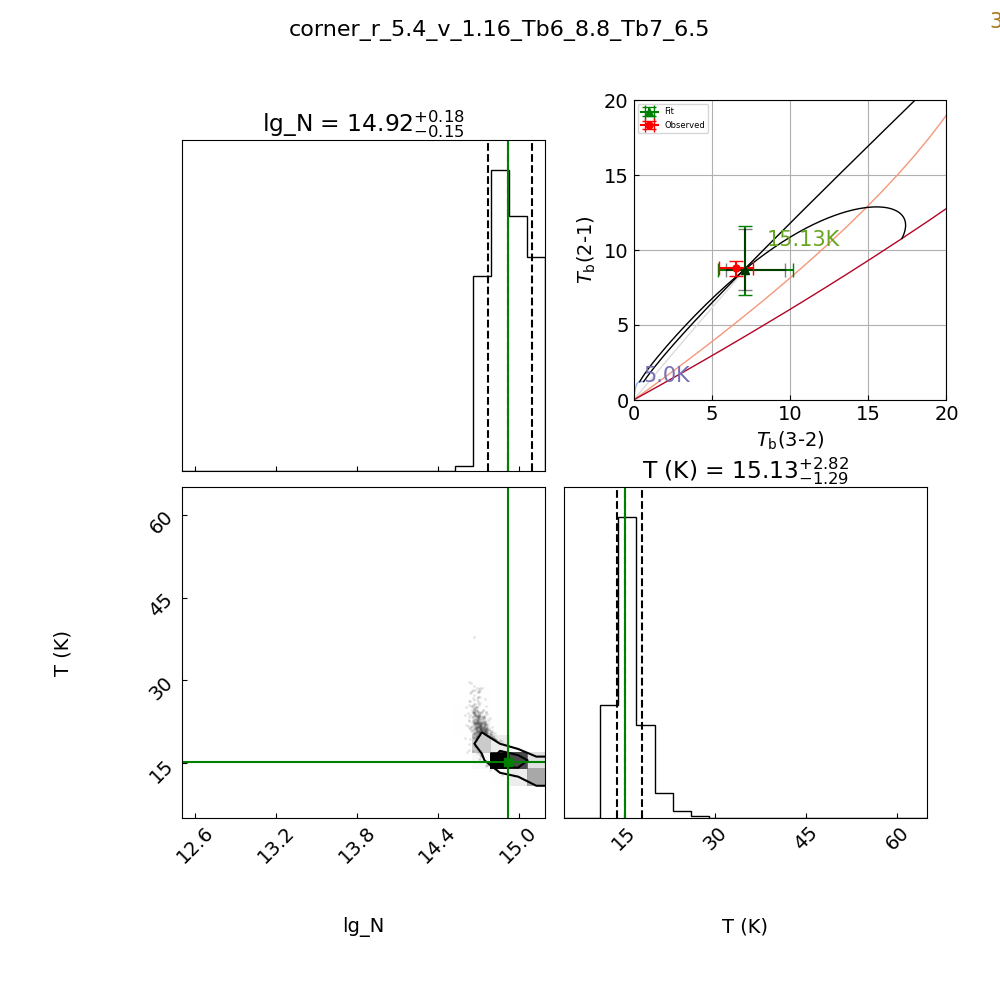

estimating for r = 5.700e+00 arcsec, v =  1.13 Kmps , Tb7 = 5.8, Tb6 = 8.4


100%|██████████| 9000/9000 [00:54<00:00, 164.95it/s]
d:\L1489_IRS_ssp\LTEAnalysis\Tb_estimator.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
C:\Users\mihirkumar\AppData\Local\Temp\ipykernel_19928\216850142.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig1 = plt.figure(figsize=(10,10))


dtauv_dT =  0.0006824073269049894
dtauv_dT =  0.00045128116225863875
Tb7_dIv_dN = 2.78e-15, Tb6_dIv_dN = 3.16e-15
Tb7_dIv_dT = 0.76, Tb6_dIv_dT = 0.83
Ncols and lgNcols up 1.26e+15, lgNc = 1.51e+01
Ncols and lgNcols med 8.36e+14, lgNc = 1.49e+01
Ncols and lgNcols dwn 5.87e+14, lgNc = 1.48e+01
del T -> + 2.47, - 1.20
del N -> + 4.26e+14, - 2.49e+14
Error propagation results:
$\Delta Tb_{6}$ [[1.26149378 2.43870441]]
$\Delta Tb_{7}$ [[1.14590252 2.22443004]]


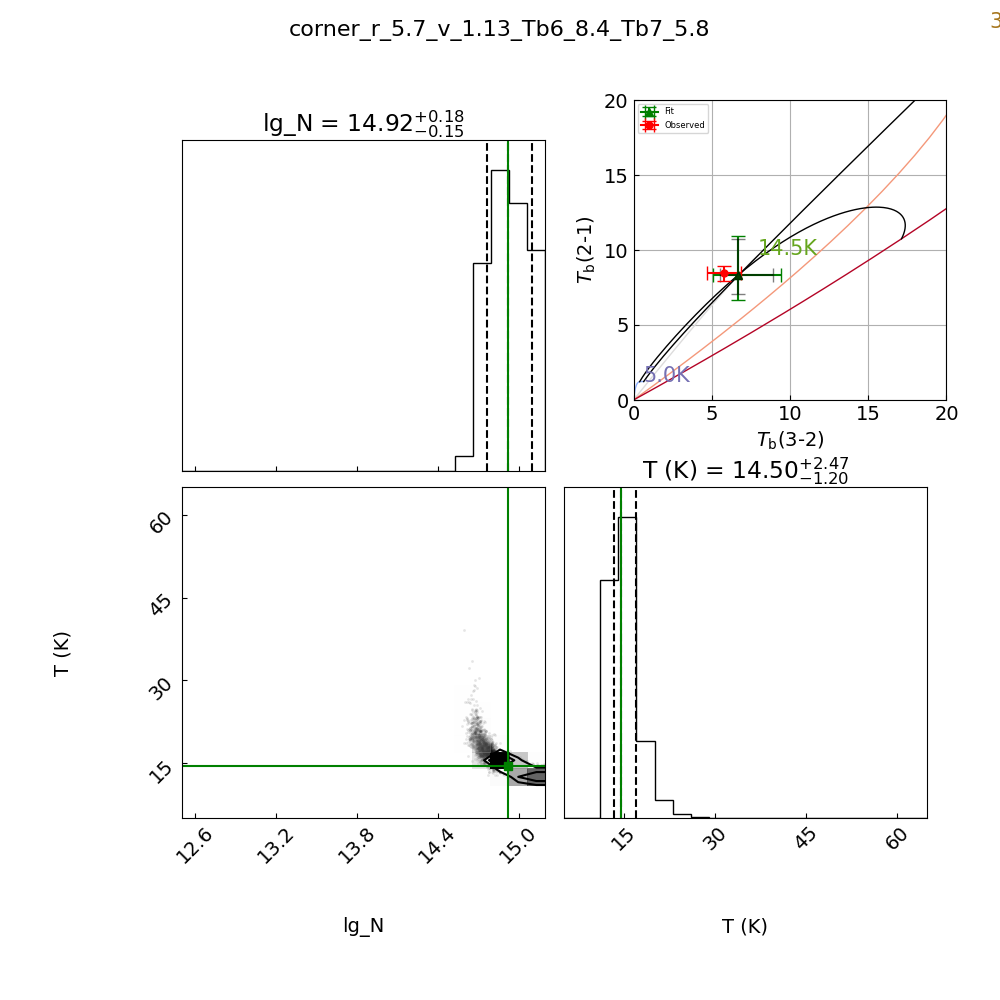

In [12]:
op_dir_label = "rs_empkep_fixr_rms_jscurve_lwerN_bnds_54"

Texe_rs_empkep_fix_r = []
Texe_upq_empkep_fix_r = []
Texe_lq_empkep_fix_r = []

Ncol_rs_empkep_fix_r = []
Ncol_upq_empkep_fix_r = []
Ncol_lq_empkep_fix_r = []

Tb_6_predictions = []
Tb_7_predictions = []


plot_corner = True

np.random.seed(41)

# N_conv_fraction = 1.e-7
lg_n_bounds = [12.5,15.2]
T_bounds = [5.,65.]
lg_n_init = np.random.uniform(lg_n_bounds[0], lg_n_bounds[-1])
T_init = np.random.uniform(T_bounds[0], T_bounds[-1])


ctr = 0

for Tb7, Tb6, r, v in zip(Tb_df_b7["Tb_on_point_rs"], Tb_df_b6["Tb_on_point_rs"], 
                          pv_b6.r_as_rs, pv_b6.v_rot_redshifted):

    print(f"estimating for r = {r:.3e} arcsec, v = {v: .2f} Kmps , Tb7 = {Tb7:.1f}, Tb6 = {Tb6:.1f}")

    flat_samples, autocorr = tb_est.estimate_params(t1 = Tb7, t2=Tb6, 
                                                    s1=np.sqrt( 1.08**2 ), #(0.1*Tb7)**2 + 1.08**2
                                                    s2=np.sqrt( 0.49**2 ),  # (0.1*Tb6)**2 + 0.49**2
                                                    estimator='mcmc', like_function = 'chisq', initial_params = [lg_n_init, T_init], 
                                                    bounds=(lg_n_bounds[0], lg_n_bounds[-1], T_bounds[0], T_bounds[-1]), 
                                                    initial_scatter = 0.1, args= None,
                                                    nwalkers = 50, n_steps = 9000, burn_in = 2000, thin_by = 50, 
                                                    return_flat= True, intensity_model = lte_model, plot_chain = True, 
                                                    r_v_info = [str(round(r,3)), str(round(v,2))], 
                                                    chain_plot_path = os.path.join(os.path.abspath(os.getcwd()),
                                                                                    "chains",op_dir_label),
                                                    show_chains = False)
    
    flat_samples_N = flat_samples[:, 0]
    flat_samples_T = flat_samples[:, 1]
    
    T_qtls = np.quantile(flat_samples_T,[0.16,0.5,0.84])
    Texe_lq_empkep_fix_r.append(T_qtls[0])
    Texe_rs_empkep_fix_r.append(T_qtls[1])
    Texe_upq_empkep_fix_r.append(T_qtls[2])

    Ncol_qtls = np.quantile(flat_samples_N,[0.16,0.5,0.84])
    Ncol_qtls = (10**Ncol_qtls)
    Ncol_lq_empkep_fix_r.append(Ncol_qtls[0])
    Ncol_rs_empkep_fix_r.append(Ncol_qtls[1])
    Ncol_upq_empkep_fix_r.append(Ncol_qtls[2])

    if plot_corner:

        fig1 = plt.figure(figsize=(10,10))
        #print(np.shape(axes1))

        fig1 = corner.corner(flat_samples, labels= ["lg_N", "T (K)"], 
                                truths=[np.log10(Ncol_qtls[1]), T_qtls[1]], 
                            truth_color = 'green', quantiles=[0.16,0.5,0.84], 
                            show_titles=True, fig = fig1, range=(lg_n_bounds, T_bounds))



        ax = fig1.add_axes(rect = [0.45,0.6,0.68,0.3])
        fig_lt, ax_lt, Tb_6_prediction, Tb_7_prediction = get_lte_grid(model=lte_model, Ncol=Ncol_qtls, 
                                Texe= T_qtls, tb7=Tb7, tb6=Tb6, figure = fig1,
                                axes = ax)
        
        Tb_6_predictions.append(Tb_6_prediction)
        Tb_7_predictions.append(Tb_7_prediction)
                            
        fig1.suptitle('corner_r_'+str(round(r,2))+'_v_'+str(round(v,2)) + '_Tb6_' + str(round(Tb6,1))+ '_Tb7_' + str(round(Tb7,1)), fontsize=16)
        fig1.subplots_adjust(top=0.86)
        figname = str(ctr) + '_corner_r_'+str(round(r,2))+'_v_'+str(round(v,2))+'.jpg'
        dir_path = os.path.join(os.path.abspath(os.getcwd()),"corner_plots",
                                op_dir_label)
        
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
        figpath = os.path.join(dir_path, figname)

        plt.show()
        fig1.savefig(fname = figpath, dpi=300, format='jpeg')
        #plt.close()

    ctr = ctr+1


In [13]:
# Calculate errorbars

T_err_empkep_rs_fix_r = [np.array(Texe_rs_empkep_fix_r)-np.array(Texe_lq_empkep_fix_r),
                         np.array(Texe_upq_empkep_fix_r)-np.array(Texe_rs_empkep_fix_r)] 

N_err_empkep_rs_fix_r = [np.array(Ncol_rs_empkep_fix_r)-np.array(Ncol_lq_empkep_fix_r), 
                         np.array(Ncol_upq_empkep_fix_r)-np.array(Ncol_rs_empkep_fix_r)]

In [14]:
# Prepare result arrays
Tb6_prediction_median = [tupple[0] for tupple in Tb_6_predictions]
Tb6_prediction_errs = [tupple[1] for tupple in Tb_6_predictions]
Tau_nu_b6 = [tupple[2] for tupple in Tb_6_predictions]
Tau_nu_errs_b6 = [tupple[3] for tupple in Tb_6_predictions]

Tb7_prediction_median = [tupple[0] for tupple in Tb_7_predictions]
Tb7_prediction_errs = [tupple[1] for tupple in Tb_7_predictions]
Tau_nu_b7 = [tupple[2] for tupple in Tb_7_predictions]
Tau_nu_errs_b7 = [tupple[3] for tupple in Tb_7_predictions]

In [15]:
results_data_fix_r = {"r_empkep_rs_fix_r": pv_b6.r_as_rs,
        "Tb7_empkep_rs_fix_r" : Tb_df_b7["Tb_on_point_rs"],
        "Tb7_empkep_rs_fix_r_prediction": Tb7_prediction_median, 
        "Tb7_empkep_rs_err_qtl_err" : Tb7_prediction_errs,
        "Tb6_empkep_rs_fix_r" : Tb_df_b6["Tb_on_point_rs"],
        "Tb6_empkep_rs_fix_r_prediction": Tb6_prediction_median,
        "Tb6_empkep_rs_err_qtl_err" : Tb6_prediction_errs,
        "Texe_rs_empkep_fix_r" : Texe_rs_empkep_fix_r, 
        "Texe_err_rs_empkep_fix_r" : np.array(T_err_empkep_rs_fix_r).T.tolist(),
        "Ncol_rs_empkep_fix_r" : Ncol_rs_empkep_fix_r, 
        "Ncol_err_rs_empkep_fix_r" : np.array(N_err_empkep_rs_fix_r).T.tolist(),
        "Tau_nu_b6" : Tau_nu_b6,
        "Tau_nu_errs_b6" : Tau_nu_errs_b6,
        "Tau_nu_b7" : Tau_nu_b7,
        "Tau_nu_errs_b7" : Tau_nu_errs_b7
        }
results_df_fix_r = pd.DataFrame(data = results_data_fix_r)

res_path = os.path.join(os.path.abspath(os.getcwd()), res_prefix+".csv")
print(res_path)
if not os.path.exists(res_path):

        df = pd.DataFrame(results_df_fix_r)
        df.to_csv(res_path, index=False)

existing_results = pd.read_csv(res_path)

updated_results = pd.concat([existing_results, results_df_fix_r], axis=1)

updated_results.to_csv(path_or_buf= res_path)

d:\L1489_IRS_ssp\LTEAnalysis\rs_empkep_fixr_rms_jscurve_lwerN_bnds_54.csv


#### Visualize results

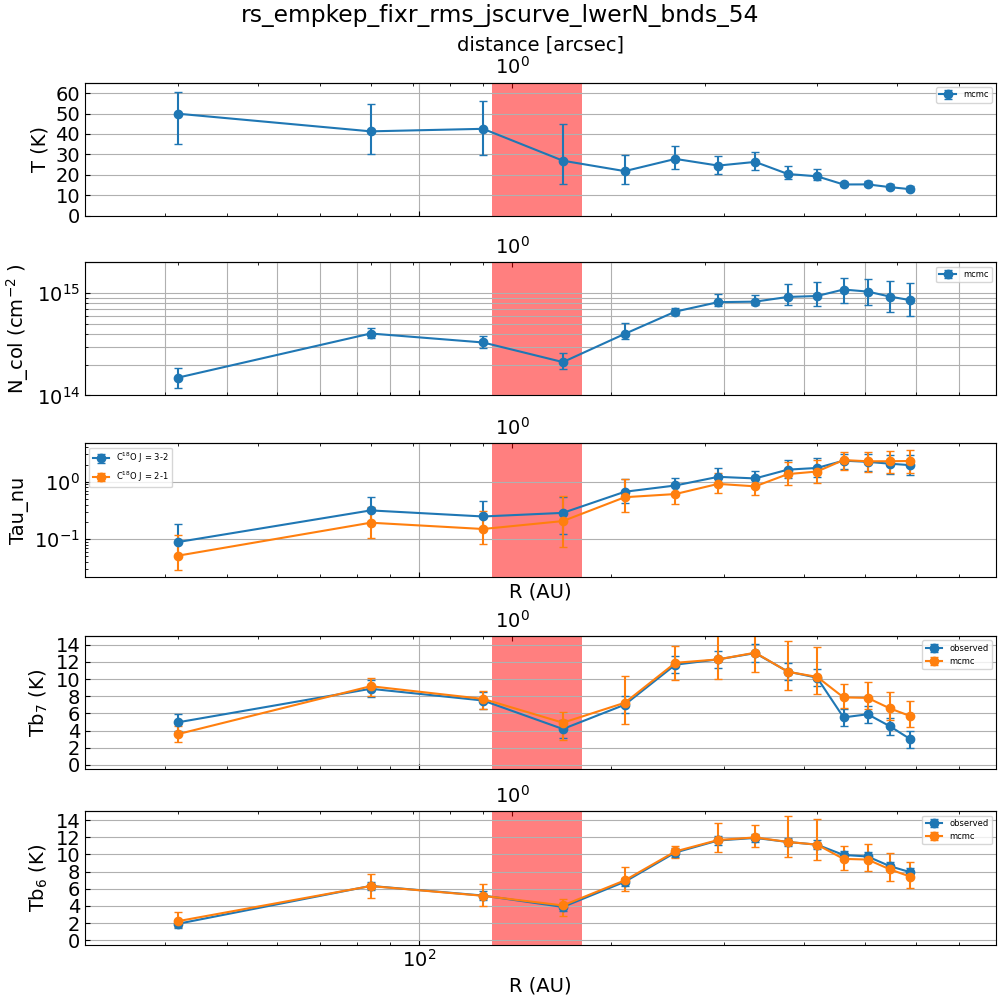

In [16]:
N_conv_fraction = 1.
vis_results_fig, axes = plt.subplots(5, figsize=(10, 10), sharex=True, layout="constrained")


acceptable_r_range = [0.3, 4.2]

ftd_r_as_rs_fix_r, ftd_Texe_rs_empkep_fix_r, \
            ftd_Terr_rs_empkep_fix_r = zip(*filter(lambda triple: 
                                                   acceptable_r_range[0] <= triple[0] <= acceptable_r_range[1], 
                                                    zip(pv_b6.r_as_rs, Texe_rs_empkep_fix_r, 
                                                    np.array(T_err_empkep_rs_fix_r).T.tolist())))

axes[0].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Texe_rs_empkep_fix_r, 
                 yerr=np.array(ftd_Terr_rs_empkep_fix_r).T, marker='o', label = 'mcmc', capsize = 3.)
axes[0].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
#axes[0].set_xlim(10, 800)
axes[0].set_ylim(0,65)
axes[0].set_yticks([0,10,20,30,40,50,60])
axes[0].set_ylabel(r"T (K)")
axes[0].grid(True)
axes[0].legend(prop={'size': 6})

secax_0 = axes[0].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
secax_0.set_xlabel('distance [arcsec]')

ftd_r_as_rs_fix_r, ftd_Ncol_rs_empkep_fix_r, ftd_N_err_rs_empkep_fix_r = zip(*[(r, t, terr) for r, t, terr in 
                                                         zip(pv_b6.r_as_rs, Ncol_rs_empkep_fix_r, np.array(N_err_empkep_rs_fix_r).T.tolist()) 
                                                         if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[1].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Ncol_rs_empkep_fix_r)*N_conv_fraction, 
                 yerr=np.array(ftd_N_err_rs_empkep_fix_r).T*N_conv_fraction, 
                 marker='o', label = 'mcmc', capsize = 3.)
axes[1].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[1].set_ylabel(r"N_col (cm$^{-2}$ )")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_ylim((1.e14,2.e15))
axes[1].grid(True, which = 'both')
axes[1].legend(prop={'size': 6})

secax_1 = axes[1].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))
#secax_1.set_xlabel('distance [arcsec]')


ftd_r_as_bs_fix_r, ftd_Tauvu_6_bs_empkep_fix_r, \
    ftd_Tauvu_6_bs_err_empkep_fix_r = zip(*[(r, tau_6, tau6_err) for r, tau_6, tau6_err in 
                                        zip(pv_b6.r_as_rs, Tau_nu_b6, 
                                            np.array(Tau_nu_errs_b6).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

ftd_r_as_bs_fix_r, ftd_Tauvu_7_bs_empkep_fix_r, \
    ftd_Tauvu_7_bs_err_empkep_fix_r = zip(*[(r, tau_7, tau7_err) for r, tau_7, tau7_err in 
                                        zip(pv_b7.r_as_rs, Tau_nu_b7, 
                                            np.array(Tau_nu_errs_b7).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_7_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_7_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 3-2', capsize = 3.)
axes[2].errorbar(np.array(ftd_r_as_rs_fix_r)*140., np.array(ftd_Tauvu_6_bs_empkep_fix_r), 
                 yerr=np.array(np.squeeze(ftd_Tauvu_6_bs_err_empkep_fix_r)).T, 
                 marker='o', label = r'C$^{18}$O J = 2-1', capsize = 3.)
axes[2].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[2].set_ylabel(r"Tau_nu")
axes[2].set_xscale('log')
axes[2].set_yscale('log')
axes[2].grid(True)
axes[2].legend(prop={'size': 6})
axes[2].set_xlabel("R (AU)")
secax_2 = axes[2].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

ftd_r_as_rs_fix_r, ftd_Tb7_rs_empkep_fix_r, \
    ftd_Tb7_rs_empkep_fix_r_prediction,\
    ftd_Tb7_rs_empkep_fix_r_prediction_err = zip(*[(r, Tb7, Tb7_pred, Tb7_pred_err) 
                                                   for r, Tb7, Tb7_pred, Tb7_pred_err in 
                                        zip(pv_b7.r_as_rs, Tb_df_b7["Tb_on_point_rs"], 
                                            Tb7_prediction_median,
                                            np.array(Tb7_prediction_errs).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])

axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb7_rs_empkep_fix_r, 
                 yerr=np.ones_like(ftd_Tb7_rs_empkep_fix_r) * 1.01,               
                 marker='o', label = 'observed', capsize = 3.)
axes[3].errorbar(np.array(ftd_r_as_rs_fix_r)*140., ftd_Tb7_rs_empkep_fix_r_prediction, 
                 yerr=np.array(np.squeeze(ftd_Tb7_rs_empkep_fix_r_prediction_err)).T,               
                 marker='o', label = 'mcmc', capsize = 3.)
axes[3].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[3].set_ylabel(r"Tb$_{7}$ (K)")
axes[3].set_ylim((-0.5,15))
axes[3].set_yticks([0,2,4,6,8,10,12,14])
axes[3].set_xscale('log')
axes[3].grid(True)
axes[3].legend(prop={'size': 6})
secax_3 = axes[3].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))


ftd_r_as_rs_fix_r, ftd_Tb6_rs_empkep_fix_r, \
    ftd_Tb6_rs_empkep_fix_r_prediction,\
    ftd_Tb6_rs_empkep_fix_r_prediction_err = zip(*[(r, Tb6, Tb6_pred, Tb6_pred_err) 
                                                   for r, Tb6, Tb6_pred, Tb6_pred_err in 
                                        zip(pv_b6.r_as_rs, Tb_df_b6["Tb_on_point_rs"], 
                                            Tb6_prediction_median,
                                            np.array(Tb6_prediction_errs).tolist()) 
                                        if acceptable_r_range[0] <= r <= acceptable_r_range[-1]])


axes[4].errorbar(np.array(ftd_r_as_bs_fix_r)*140., ftd_Tb6_rs_empkep_fix_r, 
                 yerr=np.ones_like(ftd_Tb7_rs_empkep_fix_r) * 0.49,               
                 marker='o', label = 'observed', capsize = 3.)
axes[4].errorbar(np.array(ftd_r_as_bs_fix_r)*140., ftd_Tb6_rs_empkep_fix_r_prediction, 
                 yerr=np.array(np.squeeze(ftd_Tb6_rs_empkep_fix_r_prediction_err)).T,               
                 marker='o', label = 'mcmc', capsize = 3.)
axes[4].axvspan(xmin = 130, xmax=180, facecolor='r', alpha=0.5)
axes[4].set_ylabel(r"Tb$_{6}$ (K)")
axes[4].set_ylim((-0.5,15))
axes[4].set_yticks([0,2,4,6,8,10,12,14])
axes[4].set_xscale('log')
axes[4].grid(True)
axes[4].legend(prop={'size': 6})
secax_4 = axes[4].secondary_xaxis('top', functions=(lambda x: x / 140., lambda x: 140.*x))

axes[4].set_xlabel("R (AU)")
axes[4].set_xlim(30,800)



vis_results_fig.suptitle(op_dir_label)

vis_results_figname =  'N_vs_r_T_vs_r.jpg'
dir_path = os.path.join(os.path.abspath(os.getcwd()),"vis_results",
                        op_dir_label)


if not os.path.isdir(dir_path):
    os.mkdir(dir_path)
vis_results_figpath = os.path.join(dir_path, vis_results_figname)
vis_results_fig.savefig(fname = vis_results_figpath, dpi=300, format='jpeg')